In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt

In [ ]:
####################################
import keras
print(keras.__version__)

2.9.0


170498071/170498071 [==============================] - 2s 0us/step


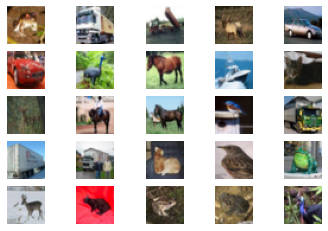

In [ ]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
  plt.subplot(5, 5, 1 + i)
  plt.axis('off')
  plt.imshow(trainX[i])
plt.show() 

In [ ]:
# binary, it has to discrimine 2 classes (real, fake)
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  
  # it's up to us to decide how many conv layers we want.
  model.add(Conv2D(128, (3,3), strides=(2,2), padding="same", input_shape=in_shape)) # 16x16x128
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding="same")) # 8x8x128
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten()) # shape of 8192
  model.add(Dropout(0.4))
  # our output is 1 because we need a value from 0 to 1 (our activation is sigmoid!!!)
  # if it is 0 our sample belongs to one class, if it is 1 to 
  model.add(Dense(1, activation='sigmoid')) # shape of 1
  # compile model
  opt = Adam(lr=0.0002, beta_1 = 0.5) # lr=learning rate beta=beta factor
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# we start with 128x8x8 nodes in the dense layer and gradually upscale to 32x32x3
# output (generated image size)

# it takes a latent vector as input and it generates an image (we want it 32x32x3). 
def define_generator(latent_dim):  # latent_dim (e.g., 100)
  model = Sequential()
  n_nodes = 128 * 8 * 8 # 8192 nodes

  # we need a dense node because as input we have a 1d vector, not an image
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  # we start with a dense layer with a node numbers equal to the total amount of our nodes
  # 8*8*128 and then we reshape it in 8,8,128 in order to be able to upscale them till 32x32
  model.add(Reshape((8, 8, 128))) # this is why we starder with 128*8*8 nodes in dense layer

  # with a kernel of (4,4) and strides(2,2) our 8x8 images goes up to 16x16.
  # how many filters we are going to have? 128
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #upsample to 16x16
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #upsample to 32x32
  model.add(LeakyReLU(alpha=0.2))
  
  # we collapse all into 3 channels (because our final output will be 32x32x3)
  # we use tanh activation because our output will go from -1 to 1.
  # For this reason we need to convert our pixel values in values between -1, 1.
  # Normally we divide by 255 to get a pixel values from 0 to 1 but in this case
  # we need -1 to 1 values.
  model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) # Generated image
  return model

  # Model not compiled as it is not directly trained like the discriminator.
  # Generator is trained via GAN combined model. 
  

In [ ]:
test_gen = define_generator(100) # size of our latent 1d vector
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [ ]:
# Define the combined generator and discriminator model, for updating the generator
# Discriminator is trained separately so here only generator will be trained
# by keeping the discriminator constant.

def define_gan(generator, discriminator):
  discriminator.trainable = False # discriminator is trained separately.

  # connect generator and discriminator
  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)

  return model

In [ ]:
# load cifar training images
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  # convert to float and scale
  X = trainX.astype('float32')
  # scale form [0,255] to [-1,1]
  X = (X - 127.5) / 127.5 # Generator uses tanh activation so rescale original
                          # images to -1 to 1 to match the output of generator
  
  return  X

In [ ]:
def generate_real_samples(dataset, n_samples):
  # choose random images
  ix = randint(0, dataset.shape[0], n_samples)
  # select the random images and assing it to X
  X = dataset[ix]
  # generate class labels and assing to y
  y = ones((n_samples, 1)) # label=1 indicating they are real

  return X, y

In [ ]:
# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples): # 100 x batch_size (how many we need)
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict using generator to generate fake samples
  X = generator.predict(x_input)
  # Class labels will be 0 as these samples are fake
  y = zeros((n_samples, 1)) # label=0 indicating they are fake
  
  return X, y

In [ ]:
# we can't simply use model.fit because this is a bit more complicated so we need 
# to iterate through n_epochs and bat_per_epo.
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch/2)
  # the discriminator model is updated for a half batch  of real samples
  # and a half batch of fake samples, combined a single batch.

  for i in range(n_epochs): # Enumerate epochs -  for these epochs..
    for j in range(bat_per_epo): # Enumerate batches - for these batches..
      X_real, y_real = generate_real_samples(dataset, half_batch) # get some real images
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real) # update D weights on real images
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) # get fake images
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake) # update D weights on fake images

      X_gan = generate_latent_points(latent_dim, n_batch) # input for the generator
      y_gan = ones((n_batch, 1)) # label generated images as true to trick the discriminator

      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    # save the generator model
    g_model.save('cifar_generator.h5')

In [ ]:
# Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=200)


2/2 [==============================] - 0s 10ms/step
Epoch>1, Batch 1/390, d1=0.699, d2=0.695, g=0.692
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 2/390, d1=0.627, d2=0.700, g=0.687
2/2 [==============================] - 0s 4ms/step
Epoch>1, Batch 3/390, d1=0.592, d2=0.709, g=0.678
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 4/390, d1=0.556, d2=0.727, g=0.662
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 5/390, d1=0.495, d2=0.753, g=0.640
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 6/390, d1=0.448, d2=0.793, g=0.614
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 7/390, d1=0.402, d2=0.838, g=0.594
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch 8/390, d1=0.372, d2=0.866, g=0.595
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch 9/390, d1=0.356, d2=0.847, g=0.634
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 10/390, d1=0.333, d2=0.7

Epoch>1, Batch 390/390, d1=0.675, d2=0.585, g=0.964
2/2 [==============================] - 0s 6ms/step
Epoch>2, Batch 1/390, d1=0.693, d2=0.540, g=0.946
2/2 [==============================] - 0s 6ms/step
Epoch>2, Batch 2/390, d1=0.721, d2=0.597, g=0.889
2/2 [==============================] - 0s 7ms/step
Epoch>2, Batch 3/390, d1=0.648, d2=0.615, g=0.942
2/2 [==============================] - 0s 5ms/step
Epoch>2, Batch 4/390, d1=0.656, d2=0.635, g=0.895
2/2 [==============================] - 0s 6ms/step
Epoch>2, Batch 5/390, d1=0.624, d2=0.648, g=0.900
2/2 [==============================] - 0s 6ms/step
Epoch>2, Batch 6/390, d1=0.682, d2=0.607, g=0.921
2/2 [==============================] - 0s 6ms/step
Epoch>2, Batch 7/390, d1=0.671, d2=0.622, g=0.925
2/2 [==============================] - 0s 6ms/step
Epoch>2, Batch 8/390, d1=0.701, d2=0.599, g=0.914
2/2 [==============================] - 0s 6ms/step
Epoch>2, Batch 9/390, d1=0.652, d2=0.591, g=0.912
2/2 [==============================] - 

Epoch>2, Batch 390/390, d1=0.716, d2=0.521, g=1.004
2/2 [==============================] - 0s 6ms/step
Epoch>3, Batch 1/390, d1=0.701, d2=0.605, g=0.953
2/2 [==============================] - 0s 5ms/step
Epoch>3, Batch 2/390, d1=0.672, d2=0.604, g=0.896
2/2 [==============================] - 0s 6ms/step
Epoch>3, Batch 3/390, d1=0.694, d2=0.623, g=0.909
2/2 [==============================] - 0s 6ms/step
Epoch>3, Batch 4/390, d1=0.643, d2=0.619, g=0.869
2/2 [==============================] - 0s 6ms/step
Epoch>3, Batch 5/390, d1=0.661, d2=0.624, g=0.888
2/2 [==============================] - 0s 6ms/step
Epoch>3, Batch 6/390, d1=0.668, d2=0.622, g=0.867
2/2 [==============================] - 0s 6ms/step
Epoch>3, Batch 7/390, d1=0.650, d2=0.607, g=0.915
2/2 [==============================] - 0s 6ms/step
Epoch>3, Batch 8/390, d1=0.687, d2=0.582, g=0.858
2/2 [==============================] - 0s 6ms/step
Epoch>3, Batch 9/390, d1=0.651, d2=0.642, g=0.929
2/2 [==============================] - 

Epoch>3, Batch 390/390, d1=0.818, d2=0.716, g=0.834
2/2 [==============================] - 0s 4ms/step
Epoch>4, Batch 1/390, d1=0.777, d2=0.651, g=0.868
2/2 [==============================] - 0s 7ms/step
Epoch>4, Batch 2/390, d1=0.802, d2=0.611, g=0.928
2/2 [==============================] - 0s 6ms/step
Epoch>4, Batch 3/390, d1=0.794, d2=0.662, g=0.859
2/2 [==============================] - 0s 6ms/step
Epoch>4, Batch 4/390, d1=0.757, d2=0.648, g=0.867
2/2 [==============================] - 0s 6ms/step
Epoch>4, Batch 5/390, d1=0.719, d2=0.649, g=0.879
2/2 [==============================] - 0s 6ms/step
Epoch>4, Batch 6/390, d1=0.726, d2=0.645, g=0.846
2/2 [==============================] - 0s 7ms/step
Epoch>4, Batch 7/390, d1=0.724, d2=0.638, g=0.841
2/2 [==============================] - 0s 7ms/step
Epoch>4, Batch 8/390, d1=0.701, d2=0.594, g=0.828
2/2 [==============================] - 0s 7ms/step
Epoch>4, Batch 9/390, d1=0.689, d2=0.651, g=0.848
2/2 [==============================] - 

Epoch>4, Batch 390/390, d1=0.616, d2=0.601, g=0.855
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 1/390, d1=0.604, d2=0.604, g=0.895
2/2 [==============================] - 0s 8ms/step
Epoch>5, Batch 2/390, d1=0.613, d2=0.581, g=0.881
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 3/390, d1=0.589, d2=0.584, g=0.884
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 4/390, d1=0.575, d2=0.614, g=0.890
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 5/390, d1=0.567, d2=0.588, g=0.859
2/2 [==============================] - 0s 8ms/step
Epoch>5, Batch 6/390, d1=0.624, d2=0.594, g=0.842
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 7/390, d1=0.630, d2=0.648, g=0.824
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 8/390, d1=0.590, d2=0.630, g=0.845
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 9/390, d1=0.638, d2=0.636, g=0.828
2/2 [==============================] - 

Epoch>5, Batch 390/390, d1=0.692, d2=0.653, g=0.768
2/2 [==============================] - 0s 7ms/step
Epoch>6, Batch 1/390, d1=0.637, d2=0.683, g=0.772
2/2 [==============================] - 0s 9ms/step
Epoch>6, Batch 2/390, d1=0.673, d2=0.691, g=0.764
2/2 [==============================] - 0s 7ms/step
Epoch>6, Batch 3/390, d1=0.666, d2=0.673, g=0.765
2/2 [==============================] - 0s 4ms/step
Epoch>6, Batch 4/390, d1=0.686, d2=0.697, g=0.752
2/2 [==============================] - 0s 6ms/step
Epoch>6, Batch 5/390, d1=0.690, d2=0.694, g=0.744
2/2 [==============================] - 0s 9ms/step
Epoch>6, Batch 6/390, d1=0.656, d2=0.713, g=0.733
2/2 [==============================] - 0s 6ms/step
Epoch>6, Batch 7/390, d1=0.685, d2=0.734, g=0.731
2/2 [==============================] - 0s 8ms/step
Epoch>6, Batch 8/390, d1=0.685, d2=0.718, g=0.736
2/2 [==============================] - 0s 8ms/step
Epoch>6, Batch 9/390, d1=0.693, d2=0.716, g=0.731
2/2 [==============================] - 

Epoch>6, Batch 390/390, d1=0.664, d2=0.611, g=0.810
2/2 [==============================] - 0s 8ms/step
Epoch>7, Batch 1/390, d1=0.663, d2=0.632, g=0.795
2/2 [==============================] - 0s 9ms/step
Epoch>7, Batch 2/390, d1=0.650, d2=0.627, g=0.777
2/2 [==============================] - 0s 8ms/step
Epoch>7, Batch 3/390, d1=0.655, d2=0.671, g=0.752
2/2 [==============================] - 0s 9ms/step
Epoch>7, Batch 4/390, d1=0.631, d2=0.671, g=0.745
2/2 [==============================] - 0s 6ms/step
Epoch>7, Batch 5/390, d1=0.606, d2=0.695, g=0.718
2/2 [==============================] - 0s 8ms/step
Epoch>7, Batch 6/390, d1=0.602, d2=0.715, g=0.721
2/2 [==============================] - 0s 6ms/step
Epoch>7, Batch 7/390, d1=0.630, d2=0.710, g=0.708
2/2 [==============================] - 0s 5ms/step
Epoch>7, Batch 8/390, d1=0.611, d2=0.719, g=0.706
2/2 [==============================] - 0s 7ms/step
Epoch>7, Batch 9/390, d1=0.615, d2=0.739, g=0.703
2/2 [==============================] - 

Epoch>7, Batch 390/390, d1=0.808, d2=0.488, g=1.092
2/2 [==============================] - 0s 5ms/step
Epoch>8, Batch 1/390, d1=0.825, d2=0.436, g=1.200
2/2 [==============================] - 0s 5ms/step
Epoch>8, Batch 2/390, d1=0.762, d2=0.373, g=1.329
2/2 [==============================] - 0s 6ms/step
Epoch>8, Batch 3/390, d1=0.734, d2=0.383, g=1.362
2/2 [==============================] - 0s 5ms/step
Epoch>8, Batch 4/390, d1=0.720, d2=0.371, g=1.341
2/2 [==============================] - 0s 6ms/step
Epoch>8, Batch 5/390, d1=0.725, d2=0.374, g=1.304
2/2 [==============================] - 0s 8ms/step
Epoch>8, Batch 6/390, d1=0.659, d2=0.409, g=1.239
2/2 [==============================] - 0s 8ms/step
Epoch>8, Batch 7/390, d1=0.607, d2=0.472, g=1.125
2/2 [==============================] - 0s 9ms/step
Epoch>8, Batch 8/390, d1=0.620, d2=0.528, g=1.024
2/2 [==============================] - 0s 8ms/step
Epoch>8, Batch 9/390, d1=0.662, d2=0.574, g=0.949
2/2 [==============================] - 

Epoch>8, Batch 390/390, d1=0.624, d2=0.775, g=0.671
2/2 [==============================] - 0s 8ms/step
Epoch>9, Batch 1/390, d1=0.616, d2=0.823, g=0.646
2/2 [==============================] - 0s 8ms/step
Epoch>9, Batch 2/390, d1=0.617, d2=0.827, g=0.668
2/2 [==============================] - 0s 10ms/step
Epoch>9, Batch 3/390, d1=0.650, d2=0.835, g=0.663
2/2 [==============================] - 0s 6ms/step
Epoch>9, Batch 4/390, d1=0.624, d2=0.799, g=0.640
2/2 [==============================] - 0s 5ms/step
Epoch>9, Batch 5/390, d1=0.642, d2=0.829, g=0.651
2/2 [==============================] - 0s 6ms/step
Epoch>9, Batch 6/390, d1=0.650, d2=0.800, g=0.636
2/2 [==============================] - 0s 6ms/step
Epoch>9, Batch 7/390, d1=0.646, d2=0.853, g=0.638
2/2 [==============================] - 0s 5ms/step
Epoch>9, Batch 8/390, d1=0.654, d2=0.831, g=0.668
2/2 [==============================] - 0s 5ms/step
Epoch>9, Batch 9/390, d1=0.686, d2=0.815, g=0.672
2/2 [==============================] -

Epoch>9, Batch 390/390, d1=0.622, d2=0.682, g=0.814
2/2 [==============================] - 0s 5ms/step
Epoch>10, Batch 1/390, d1=0.692, d2=0.709, g=0.809
2/2 [==============================] - 0s 6ms/step
Epoch>10, Batch 2/390, d1=0.666, d2=0.713, g=0.765
2/2 [==============================] - 0s 6ms/step
Epoch>10, Batch 3/390, d1=0.701, d2=0.695, g=0.707
2/2 [==============================] - 0s 9ms/step
Epoch>10, Batch 4/390, d1=0.723, d2=0.756, g=0.646
2/2 [==============================] - 0s 5ms/step
Epoch>10, Batch 5/390, d1=0.699, d2=0.866, g=0.683
2/2 [==============================] - 0s 6ms/step
Epoch>10, Batch 6/390, d1=0.744, d2=0.787, g=0.663
2/2 [==============================] - 0s 10ms/step
Epoch>10, Batch 7/390, d1=0.733, d2=0.840, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>10, Batch 8/390, d1=0.775, d2=0.722, g=0.727
2/2 [==============================] - 0s 6ms/step
Epoch>10, Batch 9/390, d1=0.779, d2=0.732, g=0.730
2/2 [========================

Epoch>10, Batch 390/390, d1=0.713, d2=0.601, g=0.844
2/2 [==============================] - 0s 9ms/step
Epoch>11, Batch 1/390, d1=0.728, d2=0.624, g=0.799
2/2 [==============================] - 0s 5ms/step
Epoch>11, Batch 2/390, d1=0.736, d2=0.669, g=0.783
2/2 [==============================] - 0s 6ms/step
Epoch>11, Batch 3/390, d1=0.687, d2=0.651, g=0.776
2/2 [==============================] - 0s 6ms/step
Epoch>11, Batch 4/390, d1=0.750, d2=0.646, g=0.755
2/2 [==============================] - 0s 7ms/step
Epoch>11, Batch 5/390, d1=0.732, d2=0.685, g=0.751
2/2 [==============================] - 0s 7ms/step
Epoch>11, Batch 6/390, d1=0.702, d2=0.686, g=0.776
2/2 [==============================] - 0s 6ms/step
Epoch>11, Batch 7/390, d1=0.699, d2=0.678, g=0.766
2/2 [==============================] - 0s 7ms/step
Epoch>11, Batch 8/390, d1=0.756, d2=0.667, g=0.777
2/2 [==============================] - 0s 12ms/step
Epoch>11, Batch 9/390, d1=0.739, d2=0.672, g=0.787
2/2 [=======================

Epoch>11, Batch 390/390, d1=0.704, d2=0.656, g=0.762
2/2 [==============================] - 0s 11ms/step
Epoch>12, Batch 1/390, d1=0.691, d2=0.679, g=0.768
2/2 [==============================] - 0s 6ms/step
Epoch>12, Batch 2/390, d1=0.707, d2=0.656, g=0.756
2/2 [==============================] - 0s 6ms/step
Epoch>12, Batch 3/390, d1=0.722, d2=0.674, g=0.747
2/2 [==============================] - 0s 5ms/step
Epoch>12, Batch 4/390, d1=0.696, d2=0.673, g=0.734
2/2 [==============================] - 0s 9ms/step
Epoch>12, Batch 5/390, d1=0.671, d2=0.688, g=0.747
2/2 [==============================] - 0s 10ms/step
Epoch>12, Batch 6/390, d1=0.715, d2=0.702, g=0.730
2/2 [==============================] - 0s 6ms/step
Epoch>12, Batch 7/390, d1=0.707, d2=0.684, g=0.739
2/2 [==============================] - 0s 9ms/step
Epoch>12, Batch 8/390, d1=0.685, d2=0.694, g=0.759
2/2 [==============================] - 0s 9ms/step
Epoch>12, Batch 9/390, d1=0.715, d2=0.682, g=0.763
2/2 [======================

Epoch>12, Batch 390/390, d1=0.757, d2=0.653, g=0.803
2/2 [==============================] - 0s 6ms/step
Epoch>13, Batch 1/390, d1=0.736, d2=0.637, g=0.833
2/2 [==============================] - 0s 5ms/step
Epoch>13, Batch 2/390, d1=0.749, d2=0.603, g=0.844
2/2 [==============================] - 0s 11ms/step
Epoch>13, Batch 3/390, d1=0.763, d2=0.607, g=0.825
2/2 [==============================] - 0s 6ms/step
Epoch>13, Batch 4/390, d1=0.757, d2=0.633, g=0.838
2/2 [==============================] - 0s 5ms/step
Epoch>13, Batch 5/390, d1=0.713, d2=0.617, g=0.825
2/2 [==============================] - 0s 5ms/step
Epoch>13, Batch 6/390, d1=0.725, d2=0.607, g=0.840
2/2 [==============================] - 0s 5ms/step
Epoch>13, Batch 7/390, d1=0.710, d2=0.627, g=0.829
2/2 [==============================] - 0s 9ms/step
Epoch>13, Batch 8/390, d1=0.717, d2=0.634, g=0.788
2/2 [==============================] - 0s 9ms/step
Epoch>13, Batch 9/390, d1=0.695, d2=0.661, g=0.765
2/2 [=======================

Epoch>13, Batch 390/390, d1=0.554, d2=0.647, g=0.798
2/2 [==============================] - 0s 6ms/step
Epoch>14, Batch 1/390, d1=0.549, d2=0.683, g=0.771
2/2 [==============================] - 0s 5ms/step
Epoch>14, Batch 2/390, d1=0.544, d2=0.716, g=0.684
2/2 [==============================] - 0s 10ms/step
Epoch>14, Batch 3/390, d1=0.598, d2=0.894, g=0.621
2/2 [==============================] - 0s 7ms/step
Epoch>14, Batch 4/390, d1=0.573, d2=0.913, g=0.596
2/2 [==============================] - 0s 7ms/step
Epoch>14, Batch 5/390, d1=0.559, d2=0.964, g=0.612
2/2 [==============================] - 0s 4ms/step
Epoch>14, Batch 6/390, d1=0.641, d2=0.870, g=0.634
2/2 [==============================] - 0s 9ms/step
Epoch>14, Batch 7/390, d1=0.684, d2=0.777, g=0.755
2/2 [==============================] - 0s 11ms/step
Epoch>14, Batch 8/390, d1=0.673, d2=0.702, g=0.789
2/2 [==============================] - 0s 5ms/step
Epoch>14, Batch 9/390, d1=0.710, d2=0.716, g=0.773
2/2 [======================

Epoch>14, Batch 390/390, d1=0.685, d2=0.722, g=0.739
2/2 [==============================] - 0s 5ms/step
Epoch>15, Batch 1/390, d1=0.669, d2=0.679, g=0.772
2/2 [==============================] - 0s 13ms/step
Epoch>15, Batch 2/390, d1=0.675, d2=0.667, g=0.834
2/2 [==============================] - 0s 10ms/step
Epoch>15, Batch 3/390, d1=0.676, d2=0.644, g=0.807
2/2 [==============================] - 0s 10ms/step
Epoch>15, Batch 4/390, d1=0.687, d2=0.635, g=0.827
2/2 [==============================] - 0s 6ms/step
Epoch>15, Batch 5/390, d1=0.696, d2=0.658, g=0.786
2/2 [==============================] - 0s 7ms/step
Epoch>15, Batch 6/390, d1=0.702, d2=0.669, g=0.791
2/2 [==============================] - 0s 4ms/step
Epoch>15, Batch 7/390, d1=0.722, d2=0.696, g=0.783
2/2 [==============================] - 0s 11ms/step
Epoch>15, Batch 8/390, d1=0.670, d2=0.706, g=0.768
2/2 [==============================] - 0s 5ms/step
Epoch>15, Batch 9/390, d1=0.716, d2=0.706, g=0.743
2/2 [====================

Epoch>15, Batch 390/390, d1=0.646, d2=0.658, g=0.784
2/2 [==============================] - 0s 11ms/step
Epoch>16, Batch 1/390, d1=0.667, d2=0.639, g=0.792
2/2 [==============================] - 0s 5ms/step
Epoch>16, Batch 2/390, d1=0.678, d2=0.710, g=0.757
2/2 [==============================] - 0s 8ms/step
Epoch>16, Batch 3/390, d1=0.666, d2=0.685, g=0.787
2/2 [==============================] - 0s 6ms/step
Epoch>16, Batch 4/390, d1=0.668, d2=0.696, g=0.785
2/2 [==============================] - 0s 7ms/step
Epoch>16, Batch 5/390, d1=0.660, d2=0.645, g=0.785
2/2 [==============================] - 0s 7ms/step
Epoch>16, Batch 6/390, d1=0.718, d2=0.684, g=0.748
2/2 [==============================] - 0s 6ms/step
Epoch>16, Batch 7/390, d1=0.671, d2=0.766, g=0.751
2/2 [==============================] - 0s 6ms/step
Epoch>16, Batch 8/390, d1=0.657, d2=0.711, g=0.753
2/2 [==============================] - 0s 11ms/step
Epoch>16, Batch 9/390, d1=0.724, d2=0.684, g=0.768
2/2 [======================

Epoch>16, Batch 390/390, d1=0.659, d2=0.692, g=0.763
2/2 [==============================] - 0s 11ms/step
Epoch>17, Batch 1/390, d1=0.663, d2=0.681, g=0.748
2/2 [==============================] - 0s 5ms/step
Epoch>17, Batch 2/390, d1=0.672, d2=0.697, g=0.728
2/2 [==============================] - 0s 5ms/step
Epoch>17, Batch 3/390, d1=0.648, d2=0.677, g=0.724
2/2 [==============================] - 0s 6ms/step
Epoch>17, Batch 4/390, d1=0.667, d2=0.702, g=0.716
2/2 [==============================] - 0s 5ms/step
Epoch>17, Batch 5/390, d1=0.653, d2=0.738, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>17, Batch 6/390, d1=0.688, d2=0.739, g=0.708
2/2 [==============================] - 0s 11ms/step
Epoch>17, Batch 7/390, d1=0.634, d2=0.707, g=0.731
2/2 [==============================] - 0s 5ms/step
Epoch>17, Batch 8/390, d1=0.681, d2=0.707, g=0.728
2/2 [==============================] - 0s 11ms/step
Epoch>17, Batch 9/390, d1=0.670, d2=0.681, g=0.766
2/2 [=====================

Epoch>17, Batch 390/390, d1=0.696, d2=0.696, g=0.758
2/2 [==============================] - 0s 5ms/step
Epoch>18, Batch 1/390, d1=0.700, d2=0.692, g=0.767
2/2 [==============================] - 0s 5ms/step
Epoch>18, Batch 2/390, d1=0.721, d2=0.652, g=0.765
2/2 [==============================] - 0s 12ms/step
Epoch>18, Batch 3/390, d1=0.733, d2=0.680, g=0.766
2/2 [==============================] - 0s 12ms/step
Epoch>18, Batch 4/390, d1=0.712, d2=0.682, g=0.745
2/2 [==============================] - 0s 11ms/step
Epoch>18, Batch 5/390, d1=0.709, d2=0.697, g=0.732
2/2 [==============================] - 0s 7ms/step
Epoch>18, Batch 6/390, d1=0.704, d2=0.693, g=0.750
2/2 [==============================] - 0s 8ms/step
Epoch>18, Batch 7/390, d1=0.696, d2=0.693, g=0.761
2/2 [==============================] - 0s 5ms/step
Epoch>18, Batch 8/390, d1=0.689, d2=0.666, g=0.743
2/2 [==============================] - 0s 6ms/step
Epoch>18, Batch 9/390, d1=0.706, d2=0.681, g=0.745
2/2 [=====================

Epoch>18, Batch 390/390, d1=0.714, d2=0.694, g=0.734
2/2 [==============================] - 0s 6ms/step
Epoch>19, Batch 1/390, d1=0.693, d2=0.702, g=0.739
2/2 [==============================] - 0s 5ms/step
Epoch>19, Batch 2/390, d1=0.736, d2=0.718, g=0.710
2/2 [==============================] - 0s 8ms/step
Epoch>19, Batch 3/390, d1=0.713, d2=0.706, g=0.751
2/2 [==============================] - 0s 4ms/step
Epoch>19, Batch 4/390, d1=0.707, d2=0.675, g=0.779
2/2 [==============================] - 0s 6ms/step
Epoch>19, Batch 5/390, d1=0.717, d2=0.630, g=0.781
2/2 [==============================] - 0s 5ms/step
Epoch>19, Batch 6/390, d1=0.761, d2=0.667, g=0.754
2/2 [==============================] - 0s 9ms/step
Epoch>19, Batch 7/390, d1=0.716, d2=0.664, g=0.751
2/2 [==============================] - 0s 11ms/step
Epoch>19, Batch 8/390, d1=0.739, d2=0.674, g=0.761
2/2 [==============================] - 0s 12ms/step
Epoch>19, Batch 9/390, d1=0.723, d2=0.713, g=0.720
2/2 [======================

Epoch>19, Batch 390/390, d1=0.697, d2=0.638, g=0.778
2/2 [==============================] - 0s 6ms/step
Epoch>20, Batch 1/390, d1=0.676, d2=0.660, g=0.754
2/2 [==============================] - 0s 15ms/step
Epoch>20, Batch 2/390, d1=0.689, d2=0.704, g=0.710
2/2 [==============================] - 0s 10ms/step
Epoch>20, Batch 3/390, d1=0.663, d2=0.719, g=0.673
2/2 [==============================] - 0s 10ms/step
Epoch>20, Batch 4/390, d1=0.671, d2=0.747, g=0.676
2/2 [==============================] - 0s 6ms/step
Epoch>20, Batch 5/390, d1=0.681, d2=0.765, g=0.661
2/2 [==============================] - 0s 9ms/step
Epoch>20, Batch 6/390, d1=0.688, d2=0.756, g=0.677
2/2 [==============================] - 0s 5ms/step
Epoch>20, Batch 7/390, d1=0.669, d2=0.744, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>20, Batch 8/390, d1=0.699, d2=0.720, g=0.731
2/2 [==============================] - 0s 7ms/step
Epoch>20, Batch 9/390, d1=0.702, d2=0.656, g=0.750
2/2 [=====================

Epoch>20, Batch 390/390, d1=0.680, d2=0.689, g=0.753
2/2 [==============================] - 0s 4ms/step
Epoch>21, Batch 1/390, d1=0.703, d2=0.679, g=0.748
2/2 [==============================] - 0s 13ms/step
Epoch>21, Batch 2/390, d1=0.675, d2=0.680, g=0.730
2/2 [==============================] - 0s 12ms/step
Epoch>21, Batch 3/390, d1=0.692, d2=0.683, g=0.720
2/2 [==============================] - 0s 8ms/step
Epoch>21, Batch 4/390, d1=0.656, d2=0.687, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>21, Batch 5/390, d1=0.671, d2=0.719, g=0.680
2/2 [==============================] - 0s 5ms/step
Epoch>21, Batch 6/390, d1=0.689, d2=0.738, g=0.681
2/2 [==============================] - 0s 5ms/step
Epoch>21, Batch 7/390, d1=0.684, d2=0.739, g=0.701
2/2 [==============================] - 0s 8ms/step
Epoch>21, Batch 8/390, d1=0.702, d2=0.723, g=0.734
2/2 [==============================] - 0s 5ms/step
Epoch>21, Batch 9/390, d1=0.680, d2=0.696, g=0.776
2/2 [======================

Epoch>21, Batch 390/390, d1=0.683, d2=0.696, g=0.726
2/2 [==============================] - 0s 4ms/step
Epoch>22, Batch 1/390, d1=0.681, d2=0.696, g=0.715
2/2 [==============================] - 0s 8ms/step
Epoch>22, Batch 2/390, d1=0.677, d2=0.719, g=0.733
2/2 [==============================] - 0s 6ms/step
Epoch>22, Batch 3/390, d1=0.684, d2=0.696, g=0.716
2/2 [==============================] - 0s 8ms/step
Epoch>22, Batch 4/390, d1=0.701, d2=0.692, g=0.715
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch 5/390, d1=0.696, d2=0.689, g=0.730
2/2 [==============================] - 0s 13ms/step
Epoch>22, Batch 6/390, d1=0.714, d2=0.695, g=0.733
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch 7/390, d1=0.696, d2=0.667, g=0.740
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch 8/390, d1=0.696, d2=0.680, g=0.743
2/2 [==============================] - 0s 8ms/step
Epoch>22, Batch 9/390, d1=0.701, d2=0.684, g=0.743
2/2 [=======================

Epoch>22, Batch 390/390, d1=0.687, d2=0.749, g=0.685
2/2 [==============================] - 0s 6ms/step
Epoch>23, Batch 1/390, d1=0.688, d2=0.747, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>23, Batch 2/390, d1=0.695, d2=0.728, g=0.713
2/2 [==============================] - 0s 11ms/step
Epoch>23, Batch 3/390, d1=0.706, d2=0.714, g=0.694
2/2 [==============================] - 0s 12ms/step
Epoch>23, Batch 4/390, d1=0.675, d2=0.698, g=0.711
2/2 [==============================] - 0s 12ms/step
Epoch>23, Batch 5/390, d1=0.703, d2=0.721, g=0.712
2/2 [==============================] - 0s 8ms/step
Epoch>23, Batch 6/390, d1=0.684, d2=0.735, g=0.714
2/2 [==============================] - 0s 7ms/step
Epoch>23, Batch 7/390, d1=0.705, d2=0.731, g=0.723
2/2 [==============================] - 0s 6ms/step
Epoch>23, Batch 8/390, d1=0.710, d2=0.700, g=0.746
2/2 [==============================] - 0s 5ms/step
Epoch>23, Batch 9/390, d1=0.732, d2=0.667, g=0.750
2/2 [=====================

Epoch>23, Batch 390/390, d1=0.663, d2=0.704, g=0.712
2/2 [==============================] - 0s 12ms/step
Epoch>24, Batch 1/390, d1=0.678, d2=0.697, g=0.713
2/2 [==============================] - 0s 5ms/step
Epoch>24, Batch 2/390, d1=0.654, d2=0.724, g=0.695
2/2 [==============================] - 0s 8ms/step
Epoch>24, Batch 3/390, d1=0.664, d2=0.737, g=0.673
2/2 [==============================] - 0s 10ms/step
Epoch>24, Batch 4/390, d1=0.693, d2=0.776, g=0.657
2/2 [==============================] - 0s 4ms/step
Epoch>24, Batch 5/390, d1=0.671, d2=0.785, g=0.673
2/2 [==============================] - 0s 6ms/step
Epoch>24, Batch 6/390, d1=0.681, d2=0.751, g=0.682
2/2 [==============================] - 0s 5ms/step
Epoch>24, Batch 7/390, d1=0.677, d2=0.705, g=0.706
2/2 [==============================] - 0s 6ms/step
Epoch>24, Batch 8/390, d1=0.704, d2=0.693, g=0.728
2/2 [==============================] - 0s 5ms/step
Epoch>24, Batch 9/390, d1=0.707, d2=0.695, g=0.736
2/2 [======================

Epoch>24, Batch 390/390, d1=0.710, d2=0.612, g=0.794
2/2 [==============================] - 0s 4ms/step
Epoch>25, Batch 1/390, d1=0.695, d2=0.625, g=0.812
2/2 [==============================] - 0s 5ms/step
Epoch>25, Batch 2/390, d1=0.723, d2=0.630, g=0.785
2/2 [==============================] - 0s 9ms/step
Epoch>25, Batch 3/390, d1=0.731, d2=0.665, g=0.766
2/2 [==============================] - 0s 4ms/step
Epoch>25, Batch 4/390, d1=0.737, d2=0.698, g=0.725
2/2 [==============================] - 0s 6ms/step
Epoch>25, Batch 5/390, d1=0.684, d2=0.714, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>25, Batch 6/390, d1=0.702, d2=0.740, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>25, Batch 7/390, d1=0.700, d2=0.743, g=0.701
2/2 [==============================] - 0s 10ms/step
Epoch>25, Batch 8/390, d1=0.682, d2=0.732, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>25, Batch 9/390, d1=0.680, d2=0.709, g=0.721
2/2 [=======================

Epoch>25, Batch 390/390, d1=0.696, d2=0.697, g=0.713
2/2 [==============================] - 0s 11ms/step
Epoch>26, Batch 1/390, d1=0.689, d2=0.714, g=0.718
2/2 [==============================] - 0s 8ms/step
Epoch>26, Batch 2/390, d1=0.680, d2=0.700, g=0.721
2/2 [==============================] - 0s 4ms/step
Epoch>26, Batch 3/390, d1=0.712, d2=0.685, g=0.735
2/2 [==============================] - 0s 8ms/step
Epoch>26, Batch 4/390, d1=0.698, d2=0.669, g=0.749
2/2 [==============================] - 0s 14ms/step
Epoch>26, Batch 5/390, d1=0.717, d2=0.669, g=0.767
2/2 [==============================] - 0s 4ms/step
Epoch>26, Batch 6/390, d1=0.697, d2=0.628, g=0.761
2/2 [==============================] - 0s 15ms/step
Epoch>26, Batch 7/390, d1=0.708, d2=0.645, g=0.795
2/2 [==============================] - 0s 14ms/step
Epoch>26, Batch 8/390, d1=0.722, d2=0.675, g=0.750
2/2 [==============================] - 0s 14ms/step
Epoch>26, Batch 9/390, d1=0.758, d2=0.690, g=0.745
2/2 [===================

Epoch>26, Batch 390/390, d1=0.719, d2=0.669, g=0.737
2/2 [==============================] - 0s 10ms/step
Epoch>27, Batch 1/390, d1=0.706, d2=0.678, g=0.725
2/2 [==============================] - 0s 6ms/step
Epoch>27, Batch 2/390, d1=0.707, d2=0.692, g=0.720
2/2 [==============================] - 0s 6ms/step
Epoch>27, Batch 3/390, d1=0.700, d2=0.682, g=0.724
2/2 [==============================] - 0s 12ms/step
Epoch>27, Batch 4/390, d1=0.710, d2=0.714, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>27, Batch 5/390, d1=0.692, d2=0.692, g=0.716
2/2 [==============================] - 0s 12ms/step
Epoch>27, Batch 6/390, d1=0.705, d2=0.701, g=0.746
2/2 [==============================] - 0s 11ms/step
Epoch>27, Batch 7/390, d1=0.689, d2=0.671, g=0.742
2/2 [==============================] - 0s 7ms/step
Epoch>27, Batch 8/390, d1=0.712, d2=0.659, g=0.755
2/2 [==============================] - 0s 5ms/step
Epoch>27, Batch 9/390, d1=0.699, d2=0.666, g=0.740
2/2 [====================

Epoch>27, Batch 390/390, d1=0.707, d2=0.674, g=0.730
2/2 [==============================] - 0s 6ms/step
Epoch>28, Batch 1/390, d1=0.715, d2=0.667, g=0.731
2/2 [==============================] - 0s 5ms/step
Epoch>28, Batch 2/390, d1=0.700, d2=0.687, g=0.744
2/2 [==============================] - 0s 5ms/step
Epoch>28, Batch 3/390, d1=0.715, d2=0.674, g=0.739
2/2 [==============================] - 0s 5ms/step
Epoch>28, Batch 4/390, d1=0.704, d2=0.679, g=0.735
2/2 [==============================] - 0s 16ms/step
Epoch>28, Batch 5/390, d1=0.696, d2=0.669, g=0.730
2/2 [==============================] - 0s 7ms/step
Epoch>28, Batch 6/390, d1=0.688, d2=0.681, g=0.738
2/2 [==============================] - 0s 6ms/step
Epoch>28, Batch 7/390, d1=0.681, d2=0.680, g=0.723
2/2 [==============================] - 0s 5ms/step
Epoch>28, Batch 8/390, d1=0.702, d2=0.690, g=0.725
2/2 [==============================] - 0s 9ms/step
Epoch>28, Batch 9/390, d1=0.692, d2=0.694, g=0.703
2/2 [=======================

Epoch>28, Batch 390/390, d1=0.687, d2=0.698, g=0.708
2/2 [==============================] - 0s 14ms/step
Epoch>29, Batch 1/390, d1=0.686, d2=0.699, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>29, Batch 2/390, d1=0.694, d2=0.703, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>29, Batch 3/390, d1=0.695, d2=0.688, g=0.711
2/2 [==============================] - 0s 5ms/step
Epoch>29, Batch 4/390, d1=0.693, d2=0.692, g=0.719
2/2 [==============================] - 0s 6ms/step
Epoch>29, Batch 5/390, d1=0.696, d2=0.688, g=0.733
2/2 [==============================] - 0s 6ms/step
Epoch>29, Batch 6/390, d1=0.707, d2=0.677, g=0.741
2/2 [==============================] - 0s 9ms/step
Epoch>29, Batch 7/390, d1=0.718, d2=0.671, g=0.736
2/2 [==============================] - 0s 7ms/step
Epoch>29, Batch 8/390, d1=0.710, d2=0.666, g=0.749
2/2 [==============================] - 0s 12ms/step
Epoch>29, Batch 9/390, d1=0.710, d2=0.659, g=0.747
2/2 [======================

Epoch>29, Batch 390/390, d1=0.698, d2=0.692, g=0.709
2/2 [==============================] - 0s 7ms/step
Epoch>30, Batch 1/390, d1=0.690, d2=0.707, g=0.715
2/2 [==============================] - 0s 5ms/step
Epoch>30, Batch 2/390, d1=0.707, d2=0.724, g=0.710
2/2 [==============================] - 0s 9ms/step
Epoch>30, Batch 3/390, d1=0.693, d2=0.689, g=0.737
2/2 [==============================] - 0s 5ms/step
Epoch>30, Batch 4/390, d1=0.711, d2=0.683, g=0.736
2/2 [==============================] - 0s 4ms/step
Epoch>30, Batch 5/390, d1=0.694, d2=0.665, g=0.737
2/2 [==============================] - 0s 4ms/step
Epoch>30, Batch 6/390, d1=0.717, d2=0.668, g=0.738
2/2 [==============================] - 0s 9ms/step
Epoch>30, Batch 7/390, d1=0.693, d2=0.674, g=0.722
2/2 [==============================] - 0s 8ms/step
Epoch>30, Batch 8/390, d1=0.682, d2=0.705, g=0.713
2/2 [==============================] - 0s 4ms/step
Epoch>30, Batch 9/390, d1=0.694, d2=0.712, g=0.683
2/2 [========================

Epoch>30, Batch 390/390, d1=0.704, d2=0.710, g=0.725
2/2 [==============================] - 0s 6ms/step
Epoch>31, Batch 1/390, d1=0.706, d2=0.682, g=0.744
2/2 [==============================] - 0s 5ms/step
Epoch>31, Batch 2/390, d1=0.706, d2=0.657, g=0.757
2/2 [==============================] - 0s 5ms/step
Epoch>31, Batch 3/390, d1=0.713, d2=0.671, g=0.756
2/2 [==============================] - 0s 5ms/step
Epoch>31, Batch 4/390, d1=0.699, d2=0.679, g=0.752
2/2 [==============================] - 0s 6ms/step
Epoch>31, Batch 5/390, d1=0.698, d2=0.699, g=0.712
2/2 [==============================] - 0s 6ms/step
Epoch>31, Batch 6/390, d1=0.677, d2=0.691, g=0.681
2/2 [==============================] - 0s 9ms/step
Epoch>31, Batch 7/390, d1=0.697, d2=0.732, g=0.675
2/2 [==============================] - 0s 6ms/step
Epoch>31, Batch 8/390, d1=0.705, d2=0.732, g=0.695
2/2 [==============================] - 0s 10ms/step
Epoch>31, Batch 9/390, d1=0.719, d2=0.704, g=0.708
2/2 [=======================

Epoch>31, Batch 390/390, d1=0.679, d2=0.696, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>32, Batch 1/390, d1=0.695, d2=0.685, g=0.711
2/2 [==============================] - 0s 6ms/step
Epoch>32, Batch 2/390, d1=0.698, d2=0.683, g=0.714
2/2 [==============================] - 0s 10ms/step
Epoch>32, Batch 3/390, d1=0.690, d2=0.691, g=0.719
2/2 [==============================] - 0s 5ms/step
Epoch>32, Batch 4/390, d1=0.696, d2=0.684, g=0.721
2/2 [==============================] - 0s 12ms/step
Epoch>32, Batch 5/390, d1=0.674, d2=0.687, g=0.711
2/2 [==============================] - 0s 8ms/step
Epoch>32, Batch 6/390, d1=0.689, d2=0.695, g=0.709
2/2 [==============================] - 0s 8ms/step
Epoch>32, Batch 7/390, d1=0.700, d2=0.714, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>32, Batch 8/390, d1=0.702, d2=0.698, g=0.697
2/2 [==============================] - 0s 13ms/step
Epoch>32, Batch 9/390, d1=0.696, d2=0.711, g=0.710
2/2 [=====================

Epoch>32, Batch 390/390, d1=0.708, d2=0.707, g=0.685
2/2 [==============================] - 0s 4ms/step
Epoch>33, Batch 1/390, d1=0.700, d2=0.728, g=0.684
2/2 [==============================] - 0s 4ms/step
Epoch>33, Batch 2/390, d1=0.681, d2=0.734, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>33, Batch 3/390, d1=0.705, d2=0.716, g=0.710
2/2 [==============================] - 0s 13ms/step
Epoch>33, Batch 4/390, d1=0.700, d2=0.684, g=0.722
2/2 [==============================] - 0s 13ms/step
Epoch>33, Batch 5/390, d1=0.700, d2=0.672, g=0.726
2/2 [==============================] - 0s 7ms/step
Epoch>33, Batch 6/390, d1=0.696, d2=0.652, g=0.744
2/2 [==============================] - 0s 11ms/step
Epoch>33, Batch 7/390, d1=0.701, d2=0.696, g=0.729
2/2 [==============================] - 0s 5ms/step
Epoch>33, Batch 8/390, d1=0.683, d2=0.689, g=0.721
2/2 [==============================] - 0s 9ms/step
Epoch>33, Batch 9/390, d1=0.698, d2=0.711, g=0.706
2/2 [=====================

Epoch>33, Batch 390/390, d1=0.703, d2=0.695, g=0.708
2/2 [==============================] - 0s 6ms/step
Epoch>34, Batch 1/390, d1=0.700, d2=0.700, g=0.690
2/2 [==============================] - 0s 8ms/step
Epoch>34, Batch 2/390, d1=0.694, d2=0.696, g=0.702
2/2 [==============================] - 0s 7ms/step
Epoch>34, Batch 3/390, d1=0.710, d2=0.705, g=0.706
2/2 [==============================] - 0s 17ms/step
Epoch>34, Batch 4/390, d1=0.708, d2=0.706, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>34, Batch 5/390, d1=0.702, d2=0.702, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>34, Batch 6/390, d1=0.704, d2=0.693, g=0.701
2/2 [==============================] - 0s 12ms/step
Epoch>34, Batch 7/390, d1=0.702, d2=0.698, g=0.711
2/2 [==============================] - 0s 13ms/step
Epoch>34, Batch 8/390, d1=0.703, d2=0.695, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>34, Batch 9/390, d1=0.708, d2=0.699, g=0.710
2/2 [=====================

Epoch>34, Batch 390/390, d1=0.705, d2=0.675, g=0.711
2/2 [==============================] - 0s 5ms/step
Epoch>35, Batch 1/390, d1=0.692, d2=0.700, g=0.716
2/2 [==============================] - 0s 5ms/step
Epoch>35, Batch 2/390, d1=0.692, d2=0.670, g=0.719
2/2 [==============================] - 0s 12ms/step
Epoch>35, Batch 3/390, d1=0.708, d2=0.679, g=0.724
2/2 [==============================] - 0s 5ms/step
Epoch>35, Batch 4/390, d1=0.706, d2=0.684, g=0.709
2/2 [==============================] - 0s 8ms/step
Epoch>35, Batch 5/390, d1=0.700, d2=0.688, g=0.707
2/2 [==============================] - 0s 8ms/step
Epoch>35, Batch 6/390, d1=0.683, d2=0.694, g=0.708
2/2 [==============================] - 0s 13ms/step
Epoch>35, Batch 7/390, d1=0.691, d2=0.697, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>35, Batch 8/390, d1=0.690, d2=0.706, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>35, Batch 9/390, d1=0.694, d2=0.692, g=0.711
2/2 [======================

Epoch>35, Batch 390/390, d1=0.693, d2=0.680, g=0.728
2/2 [==============================] - 0s 5ms/step
Epoch>36, Batch 1/390, d1=0.705, d2=0.685, g=0.726
2/2 [==============================] - 0s 5ms/step
Epoch>36, Batch 2/390, d1=0.709, d2=0.678, g=0.722
2/2 [==============================] - 0s 5ms/step
Epoch>36, Batch 3/390, d1=0.680, d2=0.677, g=0.714
2/2 [==============================] - 0s 14ms/step
Epoch>36, Batch 4/390, d1=0.707, d2=0.683, g=0.717
2/2 [==============================] - 0s 7ms/step
Epoch>36, Batch 5/390, d1=0.692, d2=0.699, g=0.712
2/2 [==============================] - 0s 15ms/step
Epoch>36, Batch 6/390, d1=0.691, d2=0.698, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>36, Batch 7/390, d1=0.697, d2=0.698, g=0.704
2/2 [==============================] - 0s 9ms/step
Epoch>36, Batch 8/390, d1=0.698, d2=0.688, g=0.702
2/2 [==============================] - 0s 15ms/step
Epoch>36, Batch 9/390, d1=0.691, d2=0.698, g=0.708
2/2 [=====================

Epoch>36, Batch 390/390, d1=0.695, d2=0.674, g=0.742
2/2 [==============================] - 0s 5ms/step
Epoch>37, Batch 1/390, d1=0.695, d2=0.686, g=0.720
2/2 [==============================] - 0s 11ms/step
Epoch>37, Batch 2/390, d1=0.717, d2=0.691, g=0.713
2/2 [==============================] - 0s 9ms/step
Epoch>37, Batch 3/390, d1=0.700, d2=0.736, g=0.712
2/2 [==============================] - 0s 9ms/step
Epoch>37, Batch 4/390, d1=0.694, d2=0.695, g=0.727
2/2 [==============================] - 0s 12ms/step
Epoch>37, Batch 5/390, d1=0.706, d2=0.677, g=0.731
2/2 [==============================] - 0s 5ms/step
Epoch>37, Batch 6/390, d1=0.710, d2=0.669, g=0.738
2/2 [==============================] - 0s 5ms/step
Epoch>37, Batch 7/390, d1=0.705, d2=0.675, g=0.742
2/2 [==============================] - 0s 5ms/step
Epoch>37, Batch 8/390, d1=0.704, d2=0.656, g=0.761
2/2 [==============================] - 0s 6ms/step
Epoch>37, Batch 9/390, d1=0.718, d2=0.653, g=0.743
2/2 [======================

Epoch>37, Batch 390/390, d1=0.691, d2=0.678, g=0.725
2/2 [==============================] - 0s 5ms/step
Epoch>38, Batch 1/390, d1=0.693, d2=0.671, g=0.719
2/2 [==============================] - 0s 8ms/step
Epoch>38, Batch 2/390, d1=0.700, d2=0.691, g=0.719
2/2 [==============================] - 0s 7ms/step
Epoch>38, Batch 3/390, d1=0.687, d2=0.702, g=0.721
2/2 [==============================] - 0s 5ms/step
Epoch>38, Batch 4/390, d1=0.691, d2=0.691, g=0.706
2/2 [==============================] - 0s 13ms/step
Epoch>38, Batch 5/390, d1=0.699, d2=0.688, g=0.710
2/2 [==============================] - 0s 9ms/step
Epoch>38, Batch 6/390, d1=0.702, d2=0.690, g=0.710
2/2 [==============================] - 0s 12ms/step
Epoch>38, Batch 7/390, d1=0.685, d2=0.690, g=0.719
2/2 [==============================] - 0s 6ms/step
Epoch>38, Batch 8/390, d1=0.700, d2=0.681, g=0.721
2/2 [==============================] - 0s 11ms/step
Epoch>38, Batch 9/390, d1=0.684, d2=0.683, g=0.719
2/2 [=====================

Epoch>38, Batch 390/390, d1=0.697, d2=0.693, g=0.708
2/2 [==============================] - 0s 10ms/step
Epoch>39, Batch 1/390, d1=0.691, d2=0.692, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>39, Batch 2/390, d1=0.695, d2=0.689, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>39, Batch 3/390, d1=0.704, d2=0.697, g=0.713
2/2 [==============================] - 0s 4ms/step
Epoch>39, Batch 4/390, d1=0.690, d2=0.684, g=0.712
2/2 [==============================] - 0s 4ms/step
Epoch>39, Batch 5/390, d1=0.678, d2=0.685, g=0.714
2/2 [==============================] - 0s 6ms/step
Epoch>39, Batch 6/390, d1=0.704, d2=0.679, g=0.714
2/2 [==============================] - 0s 5ms/step
Epoch>39, Batch 7/390, d1=0.691, d2=0.677, g=0.716
2/2 [==============================] - 0s 4ms/step
Epoch>39, Batch 8/390, d1=0.693, d2=0.685, g=0.715
2/2 [==============================] - 0s 5ms/step
Epoch>39, Batch 9/390, d1=0.715, d2=0.685, g=0.702
2/2 [=======================

Epoch>39, Batch 390/390, d1=0.683, d2=0.685, g=0.726
2/2 [==============================] - 0s 7ms/step
Epoch>40, Batch 1/390, d1=0.693, d2=0.697, g=0.726
2/2 [==============================] - 0s 6ms/step
Epoch>40, Batch 2/390, d1=0.685, d2=0.709, g=0.700
2/2 [==============================] - 0s 11ms/step
Epoch>40, Batch 3/390, d1=0.697, d2=0.696, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>40, Batch 4/390, d1=0.689, d2=0.716, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>40, Batch 5/390, d1=0.700, d2=0.708, g=0.688
2/2 [==============================] - 0s 5ms/step
Epoch>40, Batch 6/390, d1=0.702, d2=0.709, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>40, Batch 7/390, d1=0.695, d2=0.705, g=0.706
2/2 [==============================] - 0s 7ms/step
Epoch>40, Batch 8/390, d1=0.709, d2=0.694, g=0.713
2/2 [==============================] - 0s 15ms/step
Epoch>40, Batch 9/390, d1=0.707, d2=0.702, g=0.718
2/2 [======================

Epoch>40, Batch 390/390, d1=0.701, d2=0.703, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>41, Batch 1/390, d1=0.697, d2=0.690, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>41, Batch 2/390, d1=0.693, d2=0.693, g=0.709
2/2 [==============================] - 0s 11ms/step
Epoch>41, Batch 3/390, d1=0.687, d2=0.690, g=0.722
2/2 [==============================] - 0s 7ms/step
Epoch>41, Batch 4/390, d1=0.706, d2=0.691, g=0.714
2/2 [==============================] - 0s 5ms/step
Epoch>41, Batch 5/390, d1=0.685, d2=0.694, g=0.714
2/2 [==============================] - 0s 12ms/step
Epoch>41, Batch 6/390, d1=0.689, d2=0.715, g=0.713
2/2 [==============================] - 0s 5ms/step
Epoch>41, Batch 7/390, d1=0.692, d2=0.702, g=0.710
2/2 [==============================] - 0s 7ms/step
Epoch>41, Batch 8/390, d1=0.686, d2=0.703, g=0.705
2/2 [==============================] - 0s 7ms/step
Epoch>41, Batch 9/390, d1=0.681, d2=0.717, g=0.704
2/2 [======================

Epoch>41, Batch 390/390, d1=0.702, d2=0.694, g=0.713
2/2 [==============================] - 0s 4ms/step
Epoch>42, Batch 1/390, d1=0.705, d2=0.685, g=0.716
2/2 [==============================] - 0s 5ms/step
Epoch>42, Batch 2/390, d1=0.703, d2=0.682, g=0.711
2/2 [==============================] - 0s 5ms/step
Epoch>42, Batch 3/390, d1=0.713, d2=0.684, g=0.710
2/2 [==============================] - 0s 5ms/step
Epoch>42, Batch 4/390, d1=0.721, d2=0.691, g=0.711
2/2 [==============================] - 0s 4ms/step
Epoch>42, Batch 5/390, d1=0.708, d2=0.707, g=0.711
2/2 [==============================] - 0s 8ms/step
Epoch>42, Batch 6/390, d1=0.710, d2=0.687, g=0.716
2/2 [==============================] - 0s 10ms/step
Epoch>42, Batch 7/390, d1=0.711, d2=0.688, g=0.728
2/2 [==============================] - 0s 15ms/step
Epoch>42, Batch 8/390, d1=0.707, d2=0.688, g=0.717
2/2 [==============================] - 0s 4ms/step
Epoch>42, Batch 9/390, d1=0.714, d2=0.674, g=0.732
2/2 [======================

Epoch>42, Batch 390/390, d1=0.704, d2=0.686, g=0.712
2/2 [==============================] - 0s 6ms/step
Epoch>43, Batch 1/390, d1=0.708, d2=0.686, g=0.726
2/2 [==============================] - 0s 6ms/step
Epoch>43, Batch 2/390, d1=0.701, d2=0.671, g=0.724
2/2 [==============================] - 0s 4ms/step
Epoch>43, Batch 3/390, d1=0.712, d2=0.692, g=0.727
2/2 [==============================] - 0s 6ms/step
Epoch>43, Batch 4/390, d1=0.691, d2=0.689, g=0.721
2/2 [==============================] - 0s 8ms/step
Epoch>43, Batch 5/390, d1=0.706, d2=0.677, g=0.702
2/2 [==============================] - 0s 14ms/step
Epoch>43, Batch 6/390, d1=0.701, d2=0.710, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>43, Batch 7/390, d1=0.700, d2=0.704, g=0.694
2/2 [==============================] - 0s 13ms/step
Epoch>43, Batch 8/390, d1=0.708, d2=0.710, g=0.694
2/2 [==============================] - 0s 13ms/step
Epoch>43, Batch 9/390, d1=0.700, d2=0.708, g=0.695
2/2 [=====================

Epoch>43, Batch 390/390, d1=0.694, d2=0.703, g=0.694
2/2 [==============================] - 0s 7ms/step
Epoch>44, Batch 1/390, d1=0.694, d2=0.696, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>44, Batch 2/390, d1=0.689, d2=0.710, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>44, Batch 3/390, d1=0.689, d2=0.701, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>44, Batch 4/390, d1=0.693, d2=0.696, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>44, Batch 5/390, d1=0.692, d2=0.695, g=0.710
2/2 [==============================] - 0s 9ms/step
Epoch>44, Batch 6/390, d1=0.694, d2=0.682, g=0.713
2/2 [==============================] - 0s 7ms/step
Epoch>44, Batch 7/390, d1=0.697, d2=0.685, g=0.724
2/2 [==============================] - 0s 16ms/step
Epoch>44, Batch 8/390, d1=0.686, d2=0.682, g=0.721
2/2 [==============================] - 0s 4ms/step
Epoch>44, Batch 9/390, d1=0.686, d2=0.697, g=0.706
2/2 [=======================

Epoch>44, Batch 390/390, d1=0.694, d2=0.693, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>45, Batch 1/390, d1=0.705, d2=0.705, g=0.702
2/2 [==============================] - 0s 9ms/step
Epoch>45, Batch 2/390, d1=0.697, d2=0.704, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>45, Batch 3/390, d1=0.709, d2=0.692, g=0.714
2/2 [==============================] - 0s 6ms/step
Epoch>45, Batch 4/390, d1=0.702, d2=0.681, g=0.719
2/2 [==============================] - 0s 5ms/step
Epoch>45, Batch 5/390, d1=0.703, d2=0.679, g=0.731
2/2 [==============================] - 0s 11ms/step
Epoch>45, Batch 6/390, d1=0.703, d2=0.669, g=0.729
2/2 [==============================] - 0s 8ms/step
Epoch>45, Batch 7/390, d1=0.695, d2=0.674, g=0.722
2/2 [==============================] - 0s 4ms/step
Epoch>45, Batch 8/390, d1=0.679, d2=0.694, g=0.712
2/2 [==============================] - 0s 4ms/step
Epoch>45, Batch 9/390, d1=0.692, d2=0.714, g=0.676
2/2 [=======================

Epoch>45, Batch 390/390, d1=0.709, d2=0.661, g=0.748
2/2 [==============================] - 0s 4ms/step
Epoch>46, Batch 1/390, d1=0.712, d2=0.669, g=0.731
2/2 [==============================] - 0s 4ms/step
Epoch>46, Batch 2/390, d1=0.712, d2=0.678, g=0.732
2/2 [==============================] - 0s 6ms/step
Epoch>46, Batch 3/390, d1=0.711, d2=0.697, g=0.716
2/2 [==============================] - 0s 5ms/step
Epoch>46, Batch 4/390, d1=0.718, d2=0.680, g=0.715
2/2 [==============================] - 0s 5ms/step
Epoch>46, Batch 5/390, d1=0.707, d2=0.693, g=0.712
2/2 [==============================] - 0s 15ms/step
Epoch>46, Batch 6/390, d1=0.715, d2=0.702, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>46, Batch 7/390, d1=0.709, d2=0.705, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>46, Batch 8/390, d1=0.707, d2=0.707, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>46, Batch 9/390, d1=0.705, d2=0.693, g=0.705
2/2 [=======================

Epoch>46, Batch 390/390, d1=0.691, d2=0.690, g=0.703
2/2 [==============================] - 0s 12ms/step
Epoch>47, Batch 1/390, d1=0.702, d2=0.696, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>47, Batch 2/390, d1=0.702, d2=0.703, g=0.702
2/2 [==============================] - 0s 12ms/step
Epoch>47, Batch 3/390, d1=0.703, d2=0.704, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>47, Batch 4/390, d1=0.708, d2=0.705, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>47, Batch 5/390, d1=0.708, d2=0.680, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>47, Batch 6/390, d1=0.696, d2=0.686, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>47, Batch 7/390, d1=0.710, d2=0.707, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>47, Batch 8/390, d1=0.716, d2=0.688, g=0.699
2/2 [==============================] - 0s 10ms/step
Epoch>47, Batch 9/390, d1=0.700, d2=0.714, g=0.712
2/2 [=====================

Epoch>47, Batch 390/390, d1=0.701, d2=0.695, g=0.700
2/2 [==============================] - 0s 8ms/step
Epoch>48, Batch 1/390, d1=0.697, d2=0.698, g=0.701
2/2 [==============================] - 0s 9ms/step
Epoch>48, Batch 2/390, d1=0.697, d2=0.696, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>48, Batch 3/390, d1=0.700, d2=0.695, g=0.703
2/2 [==============================] - 0s 18ms/step
Epoch>48, Batch 4/390, d1=0.687, d2=0.692, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>48, Batch 5/390, d1=0.688, d2=0.690, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>48, Batch 6/390, d1=0.692, d2=0.693, g=0.701
2/2 [==============================] - 0s 9ms/step
Epoch>48, Batch 7/390, d1=0.692, d2=0.698, g=0.707
2/2 [==============================] - 0s 7ms/step
Epoch>48, Batch 8/390, d1=0.699, d2=0.688, g=0.711
2/2 [==============================] - 0s 6ms/step
Epoch>48, Batch 9/390, d1=0.698, d2=0.692, g=0.709
2/2 [=======================

Epoch>48, Batch 390/390, d1=0.676, d2=0.696, g=0.717
2/2 [==============================] - 0s 5ms/step
Epoch>49, Batch 1/390, d1=0.684, d2=0.696, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>49, Batch 2/390, d1=0.683, d2=0.702, g=0.693
2/2 [==============================] - 0s 16ms/step
Epoch>49, Batch 3/390, d1=0.686, d2=0.701, g=0.696
2/2 [==============================] - 0s 7ms/step
Epoch>49, Batch 4/390, d1=0.684, d2=0.714, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>49, Batch 5/390, d1=0.687, d2=0.710, g=0.700
2/2 [==============================] - 0s 12ms/step
Epoch>49, Batch 6/390, d1=0.689, d2=0.705, g=0.700
2/2 [==============================] - 0s 16ms/step
Epoch>49, Batch 7/390, d1=0.680, d2=0.728, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>49, Batch 8/390, d1=0.678, d2=0.696, g=0.713
2/2 [==============================] - 0s 4ms/step
Epoch>49, Batch 9/390, d1=0.692, d2=0.697, g=0.708
2/2 [=====================

Epoch>49, Batch 390/390, d1=0.702, d2=0.685, g=0.720
2/2 [==============================] - 0s 6ms/step
Epoch>50, Batch 1/390, d1=0.690, d2=0.680, g=0.729
2/2 [==============================] - 0s 9ms/step
Epoch>50, Batch 2/390, d1=0.700, d2=0.680, g=0.737
2/2 [==============================] - 0s 6ms/step
Epoch>50, Batch 3/390, d1=0.704, d2=0.673, g=0.725
2/2 [==============================] - 0s 10ms/step
Epoch>50, Batch 4/390, d1=0.690, d2=0.684, g=0.729
2/2 [==============================] - 0s 5ms/step
Epoch>50, Batch 5/390, d1=0.707, d2=0.684, g=0.716
2/2 [==============================] - 0s 12ms/step
Epoch>50, Batch 6/390, d1=0.696, d2=0.685, g=0.724
2/2 [==============================] - 0s 5ms/step
Epoch>50, Batch 7/390, d1=0.710, d2=0.694, g=0.723
2/2 [==============================] - 0s 4ms/step
Epoch>50, Batch 8/390, d1=0.704, d2=0.677, g=0.724
2/2 [==============================] - 0s 6ms/step
Epoch>50, Batch 9/390, d1=0.707, d2=0.678, g=0.725
2/2 [======================

Epoch>50, Batch 390/390, d1=0.697, d2=0.698, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>51, Batch 1/390, d1=0.695, d2=0.698, g=0.706
2/2 [==============================] - 0s 6ms/step
Epoch>51, Batch 2/390, d1=0.696, d2=0.693, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>51, Batch 3/390, d1=0.699, d2=0.699, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>51, Batch 4/390, d1=0.701, d2=0.691, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>51, Batch 5/390, d1=0.711, d2=0.698, g=0.704
2/2 [==============================] - 0s 13ms/step
Epoch>51, Batch 6/390, d1=0.704, d2=0.699, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>51, Batch 7/390, d1=0.700, d2=0.692, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>51, Batch 8/390, d1=0.702, d2=0.696, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>51, Batch 9/390, d1=0.699, d2=0.688, g=0.722
2/2 [=======================

Epoch>51, Batch 390/390, d1=0.703, d2=0.701, g=0.703
2/2 [==============================] - 0s 8ms/step
Epoch>52, Batch 1/390, d1=0.702, d2=0.694, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>52, Batch 2/390, d1=0.695, d2=0.686, g=0.712
2/2 [==============================] - 0s 4ms/step
Epoch>52, Batch 3/390, d1=0.709, d2=0.700, g=0.708
2/2 [==============================] - 0s 5ms/step
Epoch>52, Batch 4/390, d1=0.715, d2=0.691, g=0.712
2/2 [==============================] - 0s 12ms/step
Epoch>52, Batch 5/390, d1=0.703, d2=0.693, g=0.713
2/2 [==============================] - 0s 22ms/step
Epoch>52, Batch 6/390, d1=0.708, d2=0.681, g=0.711
2/2 [==============================] - 0s 10ms/step
Epoch>52, Batch 7/390, d1=0.701, d2=0.695, g=0.709
2/2 [==============================] - 0s 12ms/step
Epoch>52, Batch 8/390, d1=0.699, d2=0.692, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>52, Batch 9/390, d1=0.710, d2=0.693, g=0.702
2/2 [====================

Epoch>52, Batch 390/390, d1=0.706, d2=0.693, g=0.719
2/2 [==============================] - 0s 6ms/step
Epoch>53, Batch 1/390, d1=0.697, d2=0.692, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>53, Batch 2/390, d1=0.694, d2=0.696, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>53, Batch 3/390, d1=0.701, d2=0.700, g=0.702
2/2 [==============================] - 0s 8ms/step
Epoch>53, Batch 4/390, d1=0.695, d2=0.699, g=0.697
2/2 [==============================] - 0s 8ms/step
Epoch>53, Batch 5/390, d1=0.697, d2=0.701, g=0.694
2/2 [==============================] - 0s 9ms/step
Epoch>53, Batch 6/390, d1=0.705, d2=0.705, g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>53, Batch 7/390, d1=0.695, d2=0.703, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>53, Batch 8/390, d1=0.702, d2=0.690, g=0.710
2/2 [==============================] - 0s 6ms/step
Epoch>53, Batch 9/390, d1=0.697, d2=0.701, g=0.713
2/2 [========================

Epoch>53, Batch 390/390, d1=0.699, d2=0.699, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>54, Batch 1/390, d1=0.702, d2=0.694, g=0.710
2/2 [==============================] - 0s 4ms/step
Epoch>54, Batch 2/390, d1=0.693, d2=0.693, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>54, Batch 3/390, d1=0.688, d2=0.706, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>54, Batch 4/390, d1=0.698, d2=0.717, g=0.704
2/2 [==============================] - 0s 10ms/step
Epoch>54, Batch 5/390, d1=0.702, d2=0.689, g=0.710
2/2 [==============================] - 0s 6ms/step
Epoch>54, Batch 6/390, d1=0.696, d2=0.687, g=0.718
2/2 [==============================] - 0s 11ms/step
Epoch>54, Batch 7/390, d1=0.693, d2=0.701, g=0.718
2/2 [==============================] - 0s 5ms/step
Epoch>54, Batch 8/390, d1=0.707, d2=0.702, g=0.710
2/2 [==============================] - 0s 13ms/step
Epoch>54, Batch 9/390, d1=0.701, d2=0.688, g=0.723
2/2 [=====================

Epoch>54, Batch 390/390, d1=0.692, d2=0.691, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>55, Batch 1/390, d1=0.700, d2=0.696, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>55, Batch 2/390, d1=0.703, d2=0.695, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>55, Batch 3/390, d1=0.705, d2=0.692, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>55, Batch 4/390, d1=0.700, d2=0.691, g=0.708
2/2 [==============================] - 0s 13ms/step
Epoch>55, Batch 5/390, d1=0.696, d2=0.697, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>55, Batch 6/390, d1=0.694, d2=0.692, g=0.709
2/2 [==============================] - 0s 13ms/step
Epoch>55, Batch 7/390, d1=0.708, d2=0.688, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>55, Batch 8/390, d1=0.703, d2=0.697, g=0.705
2/2 [==============================] - 0s 12ms/step
Epoch>55, Batch 9/390, d1=0.704, d2=0.694, g=0.705
2/2 [=====================

Epoch>55, Batch 390/390, d1=0.694, d2=0.700, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>56, Batch 1/390, d1=0.695, d2=0.702, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>56, Batch 2/390, d1=0.696, d2=0.695, g=0.711
2/2 [==============================] - 0s 9ms/step
Epoch>56, Batch 3/390, d1=0.701, d2=0.693, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>56, Batch 4/390, d1=0.702, d2=0.688, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>56, Batch 5/390, d1=0.701, d2=0.687, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>56, Batch 6/390, d1=0.691, d2=0.692, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>56, Batch 7/390, d1=0.701, d2=0.688, g=0.709
2/2 [==============================] - 0s 11ms/step
Epoch>56, Batch 8/390, d1=0.695, d2=0.689, g=0.712
2/2 [==============================] - 0s 16ms/step
Epoch>56, Batch 9/390, d1=0.692, d2=0.698, g=0.704
2/2 [======================

Epoch>56, Batch 390/390, d1=0.704, d2=0.698, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>57, Batch 1/390, d1=0.697, d2=0.702, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>57, Batch 2/390, d1=0.698, d2=0.694, g=0.706
2/2 [==============================] - 0s 8ms/step
Epoch>57, Batch 3/390, d1=0.696, d2=0.688, g=0.708
2/2 [==============================] - 0s 7ms/step
Epoch>57, Batch 4/390, d1=0.687, d2=0.692, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>57, Batch 5/390, d1=0.693, d2=0.690, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>57, Batch 6/390, d1=0.697, d2=0.693, g=0.707
2/2 [==============================] - 0s 14ms/step
Epoch>57, Batch 7/390, d1=0.695, d2=0.689, g=0.706
2/2 [==============================] - 0s 13ms/step
Epoch>57, Batch 8/390, d1=0.700, d2=0.689, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>57, Batch 9/390, d1=0.699, d2=0.690, g=0.709
2/2 [======================

Epoch>57, Batch 390/390, d1=0.700, d2=0.706, g=0.699
2/2 [==============================] - 0s 10ms/step
Epoch>58, Batch 1/390, d1=0.701, d2=0.706, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>58, Batch 2/390, d1=0.701, d2=0.696, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>58, Batch 3/390, d1=0.693, d2=0.687, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>58, Batch 4/390, d1=0.685, d2=0.698, g=0.704
2/2 [==============================] - 0s 7ms/step
Epoch>58, Batch 5/390, d1=0.701, d2=0.694, g=0.703
2/2 [==============================] - 0s 12ms/step
Epoch>58, Batch 6/390, d1=0.689, d2=0.688, g=0.706
2/2 [==============================] - 0s 6ms/step
Epoch>58, Batch 7/390, d1=0.694, d2=0.689, g=0.710
2/2 [==============================] - 0s 11ms/step
Epoch>58, Batch 8/390, d1=0.700, d2=0.691, g=0.704
2/2 [==============================] - 0s 13ms/step
Epoch>58, Batch 9/390, d1=0.696, d2=0.692, g=0.705
2/2 [====================

Epoch>58, Batch 390/390, d1=0.675, d2=0.713, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>59, Batch 1/390, d1=0.698, d2=0.701, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>59, Batch 2/390, d1=0.695, d2=0.711, g=0.692
2/2 [==============================] - 0s 9ms/step
Epoch>59, Batch 3/390, d1=0.696, d2=0.710, g=0.699
2/2 [==============================] - 0s 10ms/step
Epoch>59, Batch 4/390, d1=0.703, d2=0.704, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>59, Batch 5/390, d1=0.697, d2=0.704, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>59, Batch 6/390, d1=0.696, d2=0.707, g=0.700
2/2 [==============================] - 0s 9ms/step
Epoch>59, Batch 7/390, d1=0.697, d2=0.704, g=0.693
2/2 [==============================] - 0s 12ms/step
Epoch>59, Batch 8/390, d1=0.693, d2=0.700, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>59, Batch 9/390, d1=0.697, d2=0.699, g=0.709
2/2 [======================


2/2 [==============================] - 0s 5ms/step
Epoch>60, Batch 1/390, d1=0.693, d2=0.687, g=0.711
2/2 [==============================] - 0s 5ms/step
Epoch>60, Batch 2/390, d1=0.693, d2=0.688, g=0.710
2/2 [==============================] - 0s 10ms/step
Epoch>60, Batch 3/390, d1=0.694, d2=0.684, g=0.718
2/2 [==============================] - 0s 15ms/step
Epoch>60, Batch 4/390, d1=0.691, d2=0.685, g=0.721
2/2 [==============================] - 0s 5ms/step
Epoch>60, Batch 5/390, d1=0.697, d2=0.682, g=0.714
2/2 [==============================] - 0s 9ms/step
Epoch>60, Batch 6/390, d1=0.693, d2=0.684, g=0.719
2/2 [==============================] - 0s 8ms/step
Epoch>60, Batch 7/390, d1=0.695, d2=0.687, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>60, Batch 8/390, d1=0.693, d2=0.685, g=0.706
2/2 [==============================] - 0s 6ms/step
Epoch>60, Batch 9/390, d1=0.690, d2=0.693, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>60, Batch 10/390, d1=0

Epoch>60, Batch 390/390, d1=0.694, d2=0.695, g=0.722
2/2 [==============================] - 0s 6ms/step
Epoch>61, Batch 1/390, d1=0.687, d2=0.679, g=0.735
2/2 [==============================] - 0s 5ms/step
Epoch>61, Batch 2/390, d1=0.697, d2=0.683, g=0.725
2/2 [==============================] - 0s 9ms/step
Epoch>61, Batch 3/390, d1=0.696, d2=0.687, g=0.710
2/2 [==============================] - 0s 6ms/step
Epoch>61, Batch 4/390, d1=0.697, d2=0.708, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>61, Batch 5/390, d1=0.699, d2=0.697, g=0.703
2/2 [==============================] - 0s 9ms/step
Epoch>61, Batch 6/390, d1=0.701, d2=0.696, g=0.716
2/2 [==============================] - 0s 5ms/step
Epoch>61, Batch 7/390, d1=0.699, d2=0.686, g=0.735
2/2 [==============================] - 0s 4ms/step
Epoch>61, Batch 8/390, d1=0.696, d2=0.681, g=0.725
2/2 [==============================] - 0s 11ms/step
Epoch>61, Batch 9/390, d1=0.688, d2=0.682, g=0.711
2/2 [=======================

Epoch>61, Batch 390/390, d1=0.698, d2=0.691, g=0.711
2/2 [==============================] - 0s 5ms/step
Epoch>62, Batch 1/390, d1=0.692, d2=0.692, g=0.704
2/2 [==============================] - 0s 12ms/step
Epoch>62, Batch 2/390, d1=0.697, d2=0.686, g=0.711
2/2 [==============================] - 0s 6ms/step
Epoch>62, Batch 3/390, d1=0.694, d2=0.691, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>62, Batch 4/390, d1=0.691, d2=0.695, g=0.708
2/2 [==============================] - 0s 8ms/step
Epoch>62, Batch 5/390, d1=0.691, d2=0.692, g=0.704
2/2 [==============================] - 0s 10ms/step
Epoch>62, Batch 6/390, d1=0.700, d2=0.688, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>62, Batch 7/390, d1=0.694, d2=0.709, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>62, Batch 8/390, d1=0.703, d2=0.701, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>62, Batch 9/390, d1=0.690, d2=0.695, g=0.695
2/2 [======================

Epoch>62, Batch 390/390, d1=0.690, d2=0.700, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>63, Batch 1/390, d1=0.692, d2=0.710, g=0.685
2/2 [==============================] - 0s 9ms/step
Epoch>63, Batch 2/390, d1=0.703, d2=0.716, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>63, Batch 3/390, d1=0.699, d2=0.706, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>63, Batch 4/390, d1=0.698, d2=0.703, g=0.686
2/2 [==============================] - 0s 13ms/step
Epoch>63, Batch 5/390, d1=0.692, d2=0.709, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>63, Batch 6/390, d1=0.697, d2=0.701, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>63, Batch 7/390, d1=0.698, d2=0.691, g=0.711
2/2 [==============================] - 0s 8ms/step
Epoch>63, Batch 8/390, d1=0.692, d2=0.691, g=0.713
2/2 [==============================] - 0s 6ms/step
Epoch>63, Batch 9/390, d1=0.701, d2=0.684, g=0.724
2/2 [=======================

Epoch>63, Batch 390/390, d1=0.699, d2=0.697, g=0.700
2/2 [==============================] - 0s 9ms/step
Epoch>64, Batch 1/390, d1=0.701, d2=0.696, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>64, Batch 2/390, d1=0.694, d2=0.698, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>64, Batch 3/390, d1=0.696, d2=0.698, g=0.692
2/2 [==============================] - 0s 8ms/step
Epoch>64, Batch 4/390, d1=0.692, d2=0.709, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>64, Batch 5/390, d1=0.695, d2=0.699, g=0.693
2/2 [==============================] - 0s 5ms/step
Epoch>64, Batch 6/390, d1=0.702, d2=0.705, g=0.697
2/2 [==============================] - 0s 8ms/step
Epoch>64, Batch 7/390, d1=0.694, d2=0.700, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>64, Batch 8/390, d1=0.699, d2=0.693, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>64, Batch 9/390, d1=0.695, d2=0.690, g=0.703
2/2 [========================

Epoch>64, Batch 390/390, d1=0.704, d2=0.698, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>65, Batch 1/390, d1=0.693, d2=0.696, g=0.716
2/2 [==============================] - 0s 5ms/step
Epoch>65, Batch 2/390, d1=0.697, d2=0.688, g=0.719
2/2 [==============================] - 0s 12ms/step
Epoch>65, Batch 3/390, d1=0.699, d2=0.683, g=0.715
2/2 [==============================] - 0s 5ms/step
Epoch>65, Batch 4/390, d1=0.692, d2=0.677, g=0.714
2/2 [==============================] - 0s 12ms/step
Epoch>65, Batch 5/390, d1=0.677, d2=0.677, g=0.707
2/2 [==============================] - 0s 8ms/step
Epoch>65, Batch 6/390, d1=0.696, d2=0.701, g=0.707
2/2 [==============================] - 0s 7ms/step
Epoch>65, Batch 7/390, d1=0.686, d2=0.693, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>65, Batch 8/390, d1=0.705, d2=0.715, g=0.712
2/2 [==============================] - 0s 6ms/step
Epoch>65, Batch 9/390, d1=0.695, d2=0.682, g=0.719
2/2 [======================

Epoch>65, Batch 390/390, d1=0.702, d2=0.705, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>66, Batch 1/390, d1=0.697, d2=0.691, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>66, Batch 2/390, d1=0.703, d2=0.689, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>66, Batch 3/390, d1=0.706, d2=0.686, g=0.707
2/2 [==============================] - 0s 8ms/step
Epoch>66, Batch 4/390, d1=0.691, d2=0.675, g=0.712
2/2 [==============================] - 0s 4ms/step
Epoch>66, Batch 5/390, d1=0.696, d2=0.676, g=0.707
2/2 [==============================] - 0s 8ms/step
Epoch>66, Batch 6/390, d1=0.691, d2=0.685, g=0.708
2/2 [==============================] - 0s 5ms/step
Epoch>66, Batch 7/390, d1=0.693, d2=0.700, g=0.717
2/2 [==============================] - 0s 12ms/step
Epoch>66, Batch 8/390, d1=0.698, d2=0.698, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>66, Batch 9/390, d1=0.700, d2=0.694, g=0.699
2/2 [=======================

Epoch>66, Batch 390/390, d1=0.693, d2=0.659, g=0.732
2/2 [==============================] - 0s 14ms/step
Epoch>67, Batch 1/390, d1=0.690, d2=0.690, g=0.722
2/2 [==============================] - 0s 9ms/step
Epoch>67, Batch 2/390, d1=0.703, d2=0.705, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>67, Batch 3/390, d1=0.686, d2=0.714, g=0.698
2/2 [==============================] - 0s 10ms/step
Epoch>67, Batch 4/390, d1=0.696, d2=0.711, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>67, Batch 5/390, d1=0.706, d2=0.693, g=0.715
2/2 [==============================] - 0s 5ms/step
Epoch>67, Batch 6/390, d1=0.696, d2=0.689, g=0.721
2/2 [==============================] - 0s 5ms/step
Epoch>67, Batch 7/390, d1=0.698, d2=0.673, g=0.733
2/2 [==============================] - 0s 14ms/step
Epoch>67, Batch 8/390, d1=0.700, d2=0.663, g=0.734
2/2 [==============================] - 0s 16ms/step
Epoch>67, Batch 9/390, d1=0.695, d2=0.669, g=0.740
2/2 [====================

Epoch>67, Batch 390/390, d1=0.698, d2=0.691, g=0.704
2/2 [==============================] - 0s 7ms/step
Epoch>68, Batch 1/390, d1=0.694, d2=0.694, g=0.706
2/2 [==============================] - 0s 6ms/step
Epoch>68, Batch 2/390, d1=0.702, d2=0.689, g=0.704
2/2 [==============================] - 0s 7ms/step
Epoch>68, Batch 3/390, d1=0.700, d2=0.685, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>68, Batch 4/390, d1=0.692, d2=0.687, g=0.708
2/2 [==============================] - 0s 12ms/step
Epoch>68, Batch 5/390, d1=0.698, d2=0.689, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>68, Batch 6/390, d1=0.691, d2=0.691, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>68, Batch 7/390, d1=0.708, d2=0.694, g=0.699
2/2 [==============================] - 0s 12ms/step
Epoch>68, Batch 8/390, d1=0.694, d2=0.694, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>68, Batch 9/390, d1=0.695, d2=0.701, g=0.701
2/2 [======================

Epoch>68, Batch 390/390, d1=0.703, d2=0.693, g=0.705
2/2 [==============================] - 0s 12ms/step
Epoch>69, Batch 1/390, d1=0.700, d2=0.699, g=0.700
2/2 [==============================] - 0s 9ms/step
Epoch>69, Batch 2/390, d1=0.701, d2=0.698, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>69, Batch 3/390, d1=0.702, d2=0.694, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>69, Batch 4/390, d1=0.695, d2=0.706, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>69, Batch 5/390, d1=0.696, d2=0.699, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>69, Batch 6/390, d1=0.702, d2=0.695, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>69, Batch 7/390, d1=0.698, d2=0.691, g=0.704
2/2 [==============================] - 0s 12ms/step
Epoch>69, Batch 8/390, d1=0.698, d2=0.696, g=0.705
2/2 [==============================] - 0s 11ms/step
Epoch>69, Batch 9/390, d1=0.697, d2=0.692, g=0.706
2/2 [=====================

Epoch>69, Batch 390/390, d1=0.693, d2=0.694, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>70, Batch 1/390, d1=0.699, d2=0.701, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>70, Batch 2/390, d1=0.694, d2=0.693, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>70, Batch 3/390, d1=0.694, d2=0.692, g=0.709
2/2 [==============================] - 0s 15ms/step
Epoch>70, Batch 4/390, d1=0.703, d2=0.689, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>70, Batch 5/390, d1=0.697, d2=0.688, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>70, Batch 6/390, d1=0.697, d2=0.695, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>70, Batch 7/390, d1=0.701, d2=0.681, g=0.705
2/2 [==============================] - 0s 14ms/step
Epoch>70, Batch 8/390, d1=0.698, d2=0.688, g=0.710
2/2 [==============================] - 0s 5ms/step
Epoch>70, Batch 9/390, d1=0.702, d2=0.691, g=0.711
2/2 [======================

Epoch>70, Batch 390/390, d1=0.698, d2=0.694, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>71, Batch 1/390, d1=0.692, d2=0.693, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>71, Batch 2/390, d1=0.701, d2=0.694, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>71, Batch 3/390, d1=0.690, d2=0.692, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>71, Batch 4/390, d1=0.693, d2=0.692, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>71, Batch 5/390, d1=0.690, d2=0.699, g=0.706
2/2 [==============================] - 0s 6ms/step
Epoch>71, Batch 6/390, d1=0.693, d2=0.692, g=0.705
2/2 [==============================] - 0s 7ms/step
Epoch>71, Batch 7/390, d1=0.693, d2=0.687, g=0.704
2/2 [==============================] - 0s 10ms/step
Epoch>71, Batch 8/390, d1=0.695, d2=0.699, g=0.701
2/2 [==============================] - 0s 13ms/step
Epoch>71, Batch 9/390, d1=0.696, d2=0.692, g=0.706
2/2 [======================

Epoch>71, Batch 390/390, d1=0.699, d2=0.703, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>72, Batch 1/390, d1=0.697, d2=0.698, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>72, Batch 2/390, d1=0.702, d2=0.700, g=0.693
2/2 [==============================] - 0s 7ms/step
Epoch>72, Batch 3/390, d1=0.695, d2=0.705, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>72, Batch 4/390, d1=0.701, d2=0.700, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>72, Batch 5/390, d1=0.694, d2=0.704, g=0.699
2/2 [==============================] - 0s 8ms/step
Epoch>72, Batch 6/390, d1=0.694, d2=0.697, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>72, Batch 7/390, d1=0.699, d2=0.692, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>72, Batch 8/390, d1=0.696, d2=0.688, g=0.700
2/2 [==============================] - 0s 8ms/step
Epoch>72, Batch 9/390, d1=0.696, d2=0.694, g=0.703
2/2 [========================

Epoch>72, Batch 390/390, d1=0.694, d2=0.691, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>73, Batch 1/390, d1=0.701, d2=0.702, g=0.698
2/2 [==============================] - 0s 10ms/step
Epoch>73, Batch 2/390, d1=0.693, d2=0.705, g=0.696
2/2 [==============================] - 0s 11ms/step
Epoch>73, Batch 3/390, d1=0.692, d2=0.703, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>73, Batch 4/390, d1=0.688, d2=0.700, g=0.692
2/2 [==============================] - 0s 8ms/step
Epoch>73, Batch 5/390, d1=0.698, d2=0.705, g=0.691
2/2 [==============================] - 0s 4ms/step
Epoch>73, Batch 6/390, d1=0.696, d2=0.700, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>73, Batch 7/390, d1=0.695, d2=0.698, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>73, Batch 8/390, d1=0.692, d2=0.696, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>73, Batch 9/390, d1=0.688, d2=0.693, g=0.702
2/2 [======================

Epoch>73, Batch 390/390, d1=0.696, d2=0.688, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>74, Batch 1/390, d1=0.691, d2=0.696, g=0.702
2/2 [==============================] - 0s 8ms/step
Epoch>74, Batch 2/390, d1=0.695, d2=0.707, g=0.698
2/2 [==============================] - 0s 11ms/step
Epoch>74, Batch 3/390, d1=0.694, d2=0.697, g=0.699
2/2 [==============================] - 0s 11ms/step
Epoch>74, Batch 4/390, d1=0.695, d2=0.697, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>74, Batch 5/390, d1=0.696, d2=0.695, g=0.696
2/2 [==============================] - 0s 8ms/step
Epoch>74, Batch 6/390, d1=0.690, d2=0.694, g=0.705
2/2 [==============================] - 0s 9ms/step
Epoch>74, Batch 7/390, d1=0.696, d2=0.698, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>74, Batch 8/390, d1=0.698, d2=0.696, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>74, Batch 9/390, d1=0.698, d2=0.695, g=0.703
2/2 [======================

Epoch>74, Batch 390/390, d1=0.698, d2=0.696, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>75, Batch 1/390, d1=0.696, d2=0.692, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>75, Batch 2/390, d1=0.700, d2=0.700, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>75, Batch 3/390, d1=0.703, d2=0.695, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>75, Batch 4/390, d1=0.703, d2=0.695, g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>75, Batch 5/390, d1=0.693, d2=0.698, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>75, Batch 6/390, d1=0.698, d2=0.700, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>75, Batch 7/390, d1=0.702, d2=0.692, g=0.696
2/2 [==============================] - 0s 8ms/step
Epoch>75, Batch 8/390, d1=0.699, d2=0.694, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>75, Batch 9/390, d1=0.698, d2=0.693, g=0.707
2/2 [========================

Epoch>75, Batch 390/390, d1=0.686, d2=0.701, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>76, Batch 1/390, d1=0.693, d2=0.704, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>76, Batch 2/390, d1=0.692, d2=0.700, g=0.701
2/2 [==============================] - 0s 15ms/step
Epoch>76, Batch 3/390, d1=0.692, d2=0.687, g=0.708
2/2 [==============================] - 0s 4ms/step
Epoch>76, Batch 4/390, d1=0.693, d2=0.688, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>76, Batch 5/390, d1=0.696, d2=0.694, g=0.710
2/2 [==============================] - 0s 13ms/step
Epoch>76, Batch 6/390, d1=0.698, d2=0.692, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>76, Batch 7/390, d1=0.692, d2=0.694, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>76, Batch 8/390, d1=0.707, d2=0.698, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>76, Batch 9/390, d1=0.694, d2=0.691, g=0.708
2/2 [======================

Epoch>76, Batch 390/390, d1=0.691, d2=0.694, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>77, Batch 1/390, d1=0.696, d2=0.695, g=0.700
2/2 [==============================] - 0s 12ms/step
Epoch>77, Batch 2/390, d1=0.696, d2=0.699, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>77, Batch 3/390, d1=0.698, d2=0.698, g=0.700
2/2 [==============================] - 0s 9ms/step
Epoch>77, Batch 4/390, d1=0.694, d2=0.696, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>77, Batch 5/390, d1=0.698, d2=0.691, g=0.702
2/2 [==============================] - 0s 14ms/step
Epoch>77, Batch 6/390, d1=0.695, d2=0.699, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>77, Batch 7/390, d1=0.694, d2=0.693, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>77, Batch 8/390, d1=0.693, d2=0.691, g=0.704
2/2 [==============================] - 0s 11ms/step
Epoch>77, Batch 9/390, d1=0.701, d2=0.693, g=0.709
2/2 [=====================

Epoch>77, Batch 390/390, d1=0.699, d2=0.698, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>78, Batch 1/390, d1=0.695, d2=0.693, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>78, Batch 2/390, d1=0.694, d2=0.696, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>78, Batch 3/390, d1=0.695, d2=0.686, g=0.705
2/2 [==============================] - 0s 12ms/step
Epoch>78, Batch 4/390, d1=0.693, d2=0.690, g=0.706
2/2 [==============================] - 0s 9ms/step
Epoch>78, Batch 5/390, d1=0.704, d2=0.693, g=0.698
2/2 [==============================] - 0s 10ms/step
Epoch>78, Batch 6/390, d1=0.698, d2=0.698, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>78, Batch 7/390, d1=0.695, d2=0.703, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>78, Batch 8/390, d1=0.701, d2=0.695, g=0.700
2/2 [==============================] - 0s 8ms/step
Epoch>78, Batch 9/390, d1=0.695, d2=0.695, g=0.699
2/2 [======================

Epoch>78, Batch 390/390, d1=0.700, d2=0.686, g=0.718
2/2 [==============================] - 0s 13ms/step
Epoch>79, Batch 1/390, d1=0.698, d2=0.695, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>79, Batch 2/390, d1=0.692, d2=0.700, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>79, Batch 3/390, d1=0.700, d2=0.699, g=0.708
2/2 [==============================] - 0s 4ms/step
Epoch>79, Batch 4/390, d1=0.696, d2=0.702, g=0.699
2/2 [==============================] - 0s 8ms/step
Epoch>79, Batch 5/390, d1=0.705, d2=0.690, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>79, Batch 6/390, d1=0.709, d2=0.689, g=0.711
2/2 [==============================] - 0s 8ms/step
Epoch>79, Batch 7/390, d1=0.706, d2=0.686, g=0.713
2/2 [==============================] - 0s 6ms/step
Epoch>79, Batch 8/390, d1=0.710, d2=0.682, g=0.713
2/2 [==============================] - 0s 6ms/step
Epoch>79, Batch 9/390, d1=0.705, d2=0.693, g=0.715
2/2 [=======================

Epoch>79, Batch 390/390, d1=0.696, d2=0.689, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>80, Batch 1/390, d1=0.699, d2=0.690, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>80, Batch 2/390, d1=0.701, d2=0.694, g=0.706
2/2 [==============================] - 0s 6ms/step
Epoch>80, Batch 3/390, d1=0.697, d2=0.692, g=0.703
2/2 [==============================] - 0s 10ms/step
Epoch>80, Batch 4/390, d1=0.694, d2=0.694, g=0.704
2/2 [==============================] - 0s 10ms/step
Epoch>80, Batch 5/390, d1=0.699, d2=0.692, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>80, Batch 6/390, d1=0.701, d2=0.688, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>80, Batch 7/390, d1=0.696, d2=0.694, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>80, Batch 8/390, d1=0.701, d2=0.691, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>80, Batch 9/390, d1=0.697, d2=0.687, g=0.707
2/2 [======================

Epoch>80, Batch 390/390, d1=0.699, d2=0.696, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>81, Batch 1/390, d1=0.701, d2=0.692, g=0.711
2/2 [==============================] - 0s 12ms/step
Epoch>81, Batch 2/390, d1=0.695, d2=0.685, g=0.709
2/2 [==============================] - 0s 8ms/step
Epoch>81, Batch 3/390, d1=0.693, d2=0.689, g=0.707
2/2 [==============================] - 0s 8ms/step
Epoch>81, Batch 4/390, d1=0.695, d2=0.707, g=0.703
2/2 [==============================] - 0s 11ms/step
Epoch>81, Batch 5/390, d1=0.695, d2=0.700, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>81, Batch 6/390, d1=0.692, d2=0.703, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>81, Batch 7/390, d1=0.696, d2=0.710, g=0.691
2/2 [==============================] - 0s 7ms/step
Epoch>81, Batch 8/390, d1=0.697, d2=0.705, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>81, Batch 9/390, d1=0.699, d2=0.710, g=0.694
2/2 [======================

Epoch>81, Batch 390/390, d1=0.691, d2=0.706, g=0.692
2/2 [==============================] - 0s 6ms/step
Epoch>82, Batch 1/390, d1=0.698, d2=0.700, g=0.697
2/2 [==============================] - 0s 12ms/step
Epoch>82, Batch 2/390, d1=0.697, d2=0.693, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>82, Batch 3/390, d1=0.693, d2=0.688, g=0.701
2/2 [==============================] - 0s 8ms/step
Epoch>82, Batch 4/390, d1=0.702, d2=0.689, g=0.702
2/2 [==============================] - 0s 7ms/step
Epoch>82, Batch 5/390, d1=0.702, d2=0.695, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>82, Batch 6/390, d1=0.696, d2=0.691, g=0.705
2/2 [==============================] - 0s 7ms/step
Epoch>82, Batch 7/390, d1=0.696, d2=0.687, g=0.710
2/2 [==============================] - 0s 5ms/step
Epoch>82, Batch 8/390, d1=0.698, d2=0.686, g=0.716
2/2 [==============================] - 0s 5ms/step
Epoch>82, Batch 9/390, d1=0.699, d2=0.679, g=0.717
2/2 [=======================

Epoch>82, Batch 390/390, d1=0.696, d2=0.695, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>83, Batch 1/390, d1=0.695, d2=0.691, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>83, Batch 2/390, d1=0.698, d2=0.685, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>83, Batch 3/390, d1=0.698, d2=0.687, g=0.710
2/2 [==============================] - 0s 5ms/step
Epoch>83, Batch 4/390, d1=0.694, d2=0.693, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>83, Batch 5/390, d1=0.693, d2=0.691, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>83, Batch 6/390, d1=0.695, d2=0.685, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>83, Batch 7/390, d1=0.693, d2=0.687, g=0.710
2/2 [==============================] - 0s 4ms/step
Epoch>83, Batch 8/390, d1=0.699, d2=0.689, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>83, Batch 9/390, d1=0.688, d2=0.692, g=0.703
2/2 [========================

Epoch>83, Batch 390/390, d1=0.706, d2=0.691, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>84, Batch 1/390, d1=0.693, d2=0.698, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>84, Batch 2/390, d1=0.698, d2=0.692, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>84, Batch 3/390, d1=0.699, d2=0.692, g=0.701
2/2 [==============================] - 0s 16ms/step
Epoch>84, Batch 4/390, d1=0.699, d2=0.690, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>84, Batch 5/390, d1=0.698, d2=0.697, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>84, Batch 6/390, d1=0.689, d2=0.697, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>84, Batch 7/390, d1=0.698, d2=0.694, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>84, Batch 8/390, d1=0.699, d2=0.694, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>84, Batch 9/390, d1=0.695, d2=0.689, g=0.701
2/2 [=======================

Epoch>84, Batch 390/390, d1=0.698, d2=0.696, g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>85, Batch 1/390, d1=0.697, d2=0.702, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>85, Batch 2/390, d1=0.697, d2=0.702, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>85, Batch 3/390, d1=0.692, d2=0.700, g=0.697
2/2 [==============================] - 0s 10ms/step
Epoch>85, Batch 4/390, d1=0.689, d2=0.696, g=0.702
2/2 [==============================] - 0s 11ms/step
Epoch>85, Batch 5/390, d1=0.692, d2=0.697, g=0.699
2/2 [==============================] - 0s 11ms/step
Epoch>85, Batch 6/390, d1=0.701, d2=0.693, g=0.701
2/2 [==============================] - 0s 9ms/step
Epoch>85, Batch 7/390, d1=0.697, d2=0.691, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>85, Batch 8/390, d1=0.697, d2=0.691, g=0.706
2/2 [==============================] - 0s 8ms/step
Epoch>85, Batch 9/390, d1=0.690, d2=0.688, g=0.703
2/2 [=====================

Epoch>85, Batch 390/390, d1=0.696, d2=0.695, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>86, Batch 1/390, d1=0.697, d2=0.690, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>86, Batch 2/390, d1=0.693, d2=0.700, g=0.693
2/2 [==============================] - 0s 4ms/step
Epoch>86, Batch 3/390, d1=0.695, d2=0.696, g=0.693
2/2 [==============================] - 0s 14ms/step
Epoch>86, Batch 4/390, d1=0.696, d2=0.704, g=0.692
2/2 [==============================] - 0s 4ms/step
Epoch>86, Batch 5/390, d1=0.696, d2=0.697, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>86, Batch 6/390, d1=0.691, d2=0.696, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>86, Batch 7/390, d1=0.692, d2=0.699, g=0.697
2/2 [==============================] - 0s 8ms/step
Epoch>86, Batch 8/390, d1=0.696, d2=0.693, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>86, Batch 9/390, d1=0.696, d2=0.698, g=0.700
2/2 [=======================

Epoch>86, Batch 390/390, d1=0.692, d2=0.706, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>87, Batch 1/390, d1=0.690, d2=0.706, g=0.694
2/2 [==============================] - 0s 6ms/step
Epoch>87, Batch 2/390, d1=0.695, d2=0.712, g=0.688
2/2 [==============================] - 0s 4ms/step
Epoch>87, Batch 3/390, d1=0.693, d2=0.705, g=0.688
2/2 [==============================] - 0s 4ms/step
Epoch>87, Batch 4/390, d1=0.686, d2=0.714, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>87, Batch 5/390, d1=0.692, d2=0.692, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>87, Batch 6/390, d1=0.692, d2=0.686, g=0.725
2/2 [==============================] - 0s 4ms/step
Epoch>87, Batch 7/390, d1=0.695, d2=0.672, g=0.726
2/2 [==============================] - 0s 7ms/step
Epoch>87, Batch 8/390, d1=0.699, d2=0.682, g=0.724
2/2 [==============================] - 0s 4ms/step
Epoch>87, Batch 9/390, d1=0.691, d2=0.680, g=0.727
2/2 [========================

Epoch>87, Batch 390/390, d1=0.688, d2=0.691, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>88, Batch 1/390, d1=0.693, d2=0.690, g=0.709
2/2 [==============================] - 0s 4ms/step
Epoch>88, Batch 2/390, d1=0.696, d2=0.680, g=0.726
2/2 [==============================] - 0s 6ms/step
Epoch>88, Batch 3/390, d1=0.693, d2=0.685, g=0.723
2/2 [==============================] - 0s 5ms/step
Epoch>88, Batch 4/390, d1=0.690, d2=0.691, g=0.715
2/2 [==============================] - 0s 7ms/step
Epoch>88, Batch 5/390, d1=0.696, d2=0.700, g=0.697
2/2 [==============================] - 0s 9ms/step
Epoch>88, Batch 6/390, d1=0.693, d2=0.702, g=0.701
2/2 [==============================] - 0s 12ms/step
Epoch>88, Batch 7/390, d1=0.693, d2=0.700, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>88, Batch 8/390, d1=0.689, d2=0.699, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>88, Batch 9/390, d1=0.692, d2=0.700, g=0.699
2/2 [=======================

Epoch>88, Batch 390/390, d1=0.694, d2=0.699, g=0.692
2/2 [==============================] - 0s 4ms/step
Epoch>89, Batch 1/390, d1=0.700, d2=0.693, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>89, Batch 2/390, d1=0.698, d2=0.698, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>89, Batch 3/390, d1=0.696, d2=0.694, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>89, Batch 4/390, d1=0.694, d2=0.696, g=0.705
2/2 [==============================] - 0s 7ms/step
Epoch>89, Batch 5/390, d1=0.700, d2=0.695, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>89, Batch 6/390, d1=0.706, d2=0.689, g=0.706
2/2 [==============================] - 0s 6ms/step
Epoch>89, Batch 7/390, d1=0.706, d2=0.680, g=0.714
2/2 [==============================] - 0s 5ms/step
Epoch>89, Batch 8/390, d1=0.704, d2=0.683, g=0.714
2/2 [==============================] - 0s 6ms/step
Epoch>89, Batch 9/390, d1=0.704, d2=0.683, g=0.718
2/2 [========================

Epoch>89, Batch 390/390, d1=0.695, d2=0.696, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>90, Batch 1/390, d1=0.704, d2=0.691, g=0.711
2/2 [==============================] - 0s 8ms/step
Epoch>90, Batch 2/390, d1=0.700, d2=0.683, g=0.721
2/2 [==============================] - 0s 5ms/step
Epoch>90, Batch 3/390, d1=0.707, d2=0.685, g=0.729
2/2 [==============================] - 0s 5ms/step
Epoch>90, Batch 4/390, d1=0.702, d2=0.693, g=0.720
2/2 [==============================] - 0s 6ms/step
Epoch>90, Batch 5/390, d1=0.717, d2=0.703, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>90, Batch 6/390, d1=0.709, d2=0.696, g=0.690
2/2 [==============================] - 0s 7ms/step
Epoch>90, Batch 7/390, d1=0.700, d2=0.716, g=0.692
2/2 [==============================] - 0s 6ms/step
Epoch>90, Batch 8/390, d1=0.704, d2=0.695, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>90, Batch 9/390, d1=0.700, d2=0.697, g=0.706
2/2 [========================

Epoch>90, Batch 390/390, d1=0.688, d2=0.703, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>91, Batch 1/390, d1=0.697, d2=0.697, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>91, Batch 2/390, d1=0.699, d2=0.697, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>91, Batch 3/390, d1=0.697, d2=0.692, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>91, Batch 4/390, d1=0.701, d2=0.692, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>91, Batch 5/390, d1=0.696, d2=0.687, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>91, Batch 6/390, d1=0.698, d2=0.684, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>91, Batch 7/390, d1=0.696, d2=0.689, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>91, Batch 8/390, d1=0.701, d2=0.685, g=0.709
2/2 [==============================] - 0s 4ms/step
Epoch>91, Batch 9/390, d1=0.701, d2=0.686, g=0.706
2/2 [========================

Epoch>91, Batch 390/390, d1=0.693, d2=0.705, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>92, Batch 1/390, d1=0.698, d2=0.699, g=0.695
2/2 [==============================] - 0s 12ms/step
Epoch>92, Batch 2/390, d1=0.700, d2=0.700, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>92, Batch 3/390, d1=0.696, d2=0.690, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>92, Batch 4/390, d1=0.694, d2=0.688, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>92, Batch 5/390, d1=0.700, d2=0.695, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>92, Batch 6/390, d1=0.696, d2=0.696, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>92, Batch 7/390, d1=0.702, d2=0.693, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>92, Batch 8/390, d1=0.696, d2=0.691, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>92, Batch 9/390, d1=0.696, d2=0.690, g=0.700
2/2 [=======================

Epoch>92, Batch 390/390, d1=0.697, d2=0.695, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>93, Batch 1/390, d1=0.706, d2=0.693, g=0.701
2/2 [==============================] - 0s 13ms/step
Epoch>93, Batch 2/390, d1=0.701, d2=0.700, g=0.701
2/2 [==============================] - 0s 9ms/step
Epoch>93, Batch 3/390, d1=0.701, d2=0.688, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>93, Batch 4/390, d1=0.702, d2=0.690, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>93, Batch 5/390, d1=0.706, d2=0.695, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>93, Batch 6/390, d1=0.699, d2=0.694, g=0.697
2/2 [==============================] - 0s 12ms/step
Epoch>93, Batch 7/390, d1=0.695, d2=0.697, g=0.699
2/2 [==============================] - 0s 10ms/step
Epoch>93, Batch 8/390, d1=0.699, d2=0.691, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>93, Batch 9/390, d1=0.701, d2=0.689, g=0.705
2/2 [=====================

Epoch>93, Batch 390/390, d1=0.684, d2=0.707, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>94, Batch 1/390, d1=0.680, d2=0.703, g=0.715
2/2 [==============================] - 0s 4ms/step
Epoch>94, Batch 2/390, d1=0.690, d2=0.688, g=0.715
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 3/390, d1=0.682, d2=0.700, g=0.713
2/2 [==============================] - 0s 6ms/step
Epoch>94, Batch 4/390, d1=0.683, d2=0.697, g=0.708
2/2 [==============================] - 0s 4ms/step
Epoch>94, Batch 5/390, d1=0.690, d2=0.698, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 6/390, d1=0.683, d2=0.709, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>94, Batch 7/390, d1=0.689, d2=0.707, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>94, Batch 8/390, d1=0.681, d2=0.717, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>94, Batch 9/390, d1=0.701, d2=0.706, g=0.691
2/2 [========================

Epoch>94, Batch 390/390, d1=0.698, d2=0.696, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>95, Batch 1/390, d1=0.697, d2=0.691, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>95, Batch 2/390, d1=0.695, d2=0.689, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>95, Batch 3/390, d1=0.700, d2=0.692, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>95, Batch 4/390, d1=0.693, d2=0.691, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>95, Batch 5/390, d1=0.699, d2=0.690, g=0.699
2/2 [==============================] - 0s 9ms/step
Epoch>95, Batch 6/390, d1=0.696, d2=0.687, g=0.704
2/2 [==============================] - 0s 9ms/step
Epoch>95, Batch 7/390, d1=0.693, d2=0.689, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>95, Batch 8/390, d1=0.702, d2=0.686, g=0.705
2/2 [==============================] - 0s 9ms/step
Epoch>95, Batch 9/390, d1=0.697, d2=0.690, g=0.707
2/2 [========================

Epoch>95, Batch 390/390, d1=0.703, d2=0.691, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>96, Batch 1/390, d1=0.700, d2=0.695, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>96, Batch 2/390, d1=0.700, d2=0.688, g=0.703
2/2 [==============================] - 0s 14ms/step
Epoch>96, Batch 3/390, d1=0.704, d2=0.693, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>96, Batch 4/390, d1=0.696, d2=0.693, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>96, Batch 5/390, d1=0.696, d2=0.692, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>96, Batch 6/390, d1=0.696, d2=0.693, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>96, Batch 7/390, d1=0.701, d2=0.694, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>96, Batch 8/390, d1=0.688, d2=0.691, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>96, Batch 9/390, d1=0.693, d2=0.692, g=0.703
2/2 [=======================

Epoch>96, Batch 390/390, d1=0.695, d2=0.695, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>97, Batch 1/390, d1=0.690, d2=0.702, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>97, Batch 2/390, d1=0.694, d2=0.699, g=0.692
2/2 [==============================] - 0s 6ms/step
Epoch>97, Batch 3/390, d1=0.695, d2=0.700, g=0.694
2/2 [==============================] - 0s 6ms/step
Epoch>97, Batch 4/390, d1=0.698, d2=0.701, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>97, Batch 5/390, d1=0.697, d2=0.700, g=0.693
2/2 [==============================] - 0s 7ms/step
Epoch>97, Batch 6/390, d1=0.694, d2=0.694, g=0.692
2/2 [==============================] - 0s 4ms/step
Epoch>97, Batch 7/390, d1=0.693, d2=0.704, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>97, Batch 8/390, d1=0.687, d2=0.701, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>97, Batch 9/390, d1=0.695, d2=0.701, g=0.701
2/2 [========================

Epoch>97, Batch 390/390, d1=0.692, d2=0.706, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>98, Batch 1/390, d1=0.690, d2=0.696, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>98, Batch 2/390, d1=0.690, d2=0.699, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>98, Batch 3/390, d1=0.688, d2=0.709, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>98, Batch 4/390, d1=0.689, d2=0.699, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>98, Batch 5/390, d1=0.692, d2=0.716, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>98, Batch 6/390, d1=0.693, d2=0.692, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>98, Batch 7/390, d1=0.698, d2=0.692, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>98, Batch 8/390, d1=0.690, d2=0.687, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>98, Batch 9/390, d1=0.690, d2=0.692, g=0.701
2/2 [========================

Epoch>98, Batch 390/390, d1=0.690, d2=0.699, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>99, Batch 1/390, d1=0.690, d2=0.696, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>99, Batch 2/390, d1=0.693, d2=0.698, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>99, Batch 3/390, d1=0.691, d2=0.695, g=0.704
2/2 [==============================] - 0s 12ms/step
Epoch>99, Batch 4/390, d1=0.691, d2=0.695, g=0.696
2/2 [==============================] - 0s 7ms/step
Epoch>99, Batch 5/390, d1=0.693, d2=0.708, g=0.691
2/2 [==============================] - 0s 8ms/step
Epoch>99, Batch 6/390, d1=0.693, d2=0.703, g=0.692
2/2 [==============================] - 0s 4ms/step
Epoch>99, Batch 7/390, d1=0.693, d2=0.708, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>99, Batch 8/390, d1=0.698, d2=0.706, g=0.691
2/2 [==============================] - 0s 4ms/step
Epoch>99, Batch 9/390, d1=0.695, d2=0.702, g=0.702
2/2 [=======================

Epoch>99, Batch 390/390, d1=0.686, d2=0.704, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>100, Batch 1/390, d1=0.688, d2=0.705, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>100, Batch 2/390, d1=0.689, d2=0.720, g=0.685
2/2 [==============================] - 0s 4ms/step
Epoch>100, Batch 3/390, d1=0.690, d2=0.708, g=0.689
2/2 [==============================] - 0s 4ms/step
Epoch>100, Batch 4/390, d1=0.688, d2=0.709, g=0.691
2/2 [==============================] - 0s 4ms/step
Epoch>100, Batch 5/390, d1=0.692, d2=0.695, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>100, Batch 6/390, d1=0.693, d2=0.693, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>100, Batch 7/390, d1=0.697, d2=0.686, g=0.707
2/2 [==============================] - 0s 7ms/step
Epoch>100, Batch 8/390, d1=0.690, d2=0.686, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>100, Batch 9/390, d1=0.695, d2=0.692, g=0.695
2/2 [===============

Epoch>100, Batch 390/390, d1=0.696, d2=0.686, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch 1/390, d1=0.692, d2=0.690, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch 2/390, d1=0.703, d2=0.694, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>101, Batch 3/390, d1=0.700, d2=0.687, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch 4/390, d1=0.701, d2=0.690, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch 5/390, d1=0.699, d2=0.693, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch 6/390, d1=0.699, d2=0.690, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch 7/390, d1=0.700, d2=0.685, g=0.710
2/2 [==============================] - 0s 5ms/step
Epoch>101, Batch 8/390, d1=0.695, d2=0.686, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch 9/390, d1=0.698, d2=0.687, g=0.705
2/2 [==============

Epoch>101, Batch 390/390, d1=0.697, d2=0.691, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>102, Batch 1/390, d1=0.698, d2=0.688, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>102, Batch 2/390, d1=0.693, d2=0.685, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>102, Batch 3/390, d1=0.695, d2=0.691, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>102, Batch 4/390, d1=0.690, d2=0.691, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>102, Batch 5/390, d1=0.696, d2=0.691, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>102, Batch 6/390, d1=0.691, d2=0.688, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>102, Batch 7/390, d1=0.691, d2=0.692, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>102, Batch 8/390, d1=0.690, d2=0.699, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>102, Batch 9/390, d1=0.688, d2=0.702, g=0.697
2/2 [==============

Epoch>102, Batch 390/390, d1=0.691, d2=0.694, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>103, Batch 1/390, d1=0.694, d2=0.693, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>103, Batch 2/390, d1=0.691, d2=0.699, g=0.705
2/2 [==============================] - 0s 7ms/step
Epoch>103, Batch 3/390, d1=0.701, d2=0.697, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>103, Batch 4/390, d1=0.688, d2=0.703, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>103, Batch 5/390, d1=0.693, d2=0.711, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>103, Batch 6/390, d1=0.691, d2=0.698, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>103, Batch 7/390, d1=0.698, d2=0.693, g=0.708
2/2 [==============================] - 0s 4ms/step
Epoch>103, Batch 8/390, d1=0.698, d2=0.692, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>103, Batch 9/390, d1=0.697, d2=0.694, g=0.703
2/2 [==============

Epoch>103, Batch 390/390, d1=0.692, d2=0.693, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>104, Batch 1/390, d1=0.692, d2=0.690, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>104, Batch 2/390, d1=0.694, d2=0.695, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>104, Batch 3/390, d1=0.695, d2=0.691, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>104, Batch 4/390, d1=0.696, d2=0.694, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>104, Batch 5/390, d1=0.699, d2=0.695, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>104, Batch 6/390, d1=0.691, d2=0.689, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>104, Batch 7/390, d1=0.695, d2=0.696, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>104, Batch 8/390, d1=0.692, d2=0.704, g=0.693
2/2 [==============================] - 0s 7ms/step
Epoch>104, Batch 9/390, d1=0.695, d2=0.693, g=0.695
2/2 [==============

Epoch>104, Batch 390/390, d1=0.691, d2=0.697, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>105, Batch 1/390, d1=0.687, d2=0.692, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>105, Batch 2/390, d1=0.685, d2=0.700, g=0.691
2/2 [==============================] - 0s 4ms/step
Epoch>105, Batch 3/390, d1=0.691, d2=0.704, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>105, Batch 4/390, d1=0.696, d2=0.700, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>105, Batch 5/390, d1=0.689, d2=0.697, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>105, Batch 6/390, d1=0.693, d2=0.694, g=0.696
2/2 [==============================] - 0s 7ms/step
Epoch>105, Batch 7/390, d1=0.692, d2=0.695, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>105, Batch 8/390, d1=0.695, d2=0.691, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>105, Batch 9/390, d1=0.693, d2=0.691, g=0.705
2/2 [==============

Epoch>105, Batch 390/390, d1=0.702, d2=0.692, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>106, Batch 1/390, d1=0.700, d2=0.696, g=0.700
2/2 [==============================] - 0s 8ms/step
Epoch>106, Batch 2/390, d1=0.698, d2=0.695, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>106, Batch 3/390, d1=0.698, d2=0.692, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>106, Batch 4/390, d1=0.701, d2=0.689, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>106, Batch 5/390, d1=0.701, d2=0.699, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>106, Batch 6/390, d1=0.697, d2=0.691, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>106, Batch 7/390, d1=0.694, d2=0.692, g=0.701
2/2 [==============================] - 0s 9ms/step
Epoch>106, Batch 8/390, d1=0.698, d2=0.690, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>106, Batch 9/390, d1=0.699, d2=0.693, g=0.702
2/2 [==============

Epoch>106, Batch 390/390, d1=0.696, d2=0.692, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>107, Batch 1/390, d1=0.690, d2=0.695, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>107, Batch 2/390, d1=0.697, d2=0.691, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>107, Batch 3/390, d1=0.695, d2=0.687, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>107, Batch 4/390, d1=0.699, d2=0.696, g=0.709
2/2 [==============================] - 0s 4ms/step
Epoch>107, Batch 5/390, d1=0.699, d2=0.686, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>107, Batch 6/390, d1=0.697, d2=0.693, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>107, Batch 7/390, d1=0.701, d2=0.694, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>107, Batch 8/390, d1=0.696, d2=0.700, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>107, Batch 9/390, d1=0.701, d2=0.695, g=0.696
2/2 [==============

Epoch>107, Batch 390/390, d1=0.689, d2=0.695, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>108, Batch 1/390, d1=0.694, d2=0.694, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>108, Batch 2/390, d1=0.694, d2=0.692, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>108, Batch 3/390, d1=0.697, d2=0.701, g=0.692
2/2 [==============================] - 0s 6ms/step
Epoch>108, Batch 4/390, d1=0.689, d2=0.712, g=0.689
2/2 [==============================] - 0s 7ms/step
Epoch>108, Batch 5/390, d1=0.697, d2=0.700, g=0.689
2/2 [==============================] - 0s 4ms/step
Epoch>108, Batch 6/390, d1=0.695, d2=0.706, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>108, Batch 7/390, d1=0.694, d2=0.697, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>108, Batch 8/390, d1=0.697, d2=0.696, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>108, Batch 9/390, d1=0.695, d2=0.697, g=0.700
2/2 [==============

Epoch>108, Batch 390/390, d1=0.692, d2=0.696, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>109, Batch 1/390, d1=0.696, d2=0.690, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>109, Batch 2/390, d1=0.696, d2=0.692, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>109, Batch 3/390, d1=0.694, d2=0.688, g=0.704
2/2 [==============================] - 0s 7ms/step
Epoch>109, Batch 4/390, d1=0.695, d2=0.690, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>109, Batch 5/390, d1=0.688, d2=0.686, g=0.708
2/2 [==============================] - 0s 5ms/step
Epoch>109, Batch 6/390, d1=0.692, d2=0.686, g=0.708
2/2 [==============================] - 0s 4ms/step
Epoch>109, Batch 7/390, d1=0.694, d2=0.690, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>109, Batch 8/390, d1=0.695, d2=0.691, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>109, Batch 9/390, d1=0.692, d2=0.687, g=0.704
2/2 [==============

Epoch>109, Batch 390/390, d1=0.692, d2=0.695, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch 1/390, d1=0.691, d2=0.693, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>110, Batch 2/390, d1=0.696, d2=0.695, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch 3/390, d1=0.693, d2=0.698, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch 4/390, d1=0.695, d2=0.697, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch 5/390, d1=0.690, d2=0.691, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>110, Batch 6/390, d1=0.693, d2=0.690, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch 7/390, d1=0.694, d2=0.695, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch 8/390, d1=0.695, d2=0.691, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch 9/390, d1=0.693, d2=0.699, g=0.696
2/2 [==============

Epoch>110, Batch 390/390, d1=0.695, d2=0.696, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>111, Batch 1/390, d1=0.698, d2=0.695, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>111, Batch 2/390, d1=0.694, d2=0.689, g=0.700
2/2 [==============================] - 0s 10ms/step
Epoch>111, Batch 3/390, d1=0.694, d2=0.690, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>111, Batch 4/390, d1=0.695, d2=0.701, g=0.694
2/2 [==============================] - 0s 7ms/step
Epoch>111, Batch 5/390, d1=0.692, d2=0.695, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>111, Batch 6/390, d1=0.698, d2=0.694, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>111, Batch 7/390, d1=0.698, d2=0.692, g=0.697
2/2 [==============================] - 0s 10ms/step
Epoch>111, Batch 8/390, d1=0.696, d2=0.705, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>111, Batch 9/390, d1=0.694, d2=0.697, g=0.698
2/2 [============

Epoch>111, Batch 390/390, d1=0.690, d2=0.701, g=0.689
2/2 [==============================] - 0s 7ms/step
Epoch>112, Batch 1/390, d1=0.691, d2=0.706, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>112, Batch 2/390, d1=0.692, d2=0.697, g=0.691
2/2 [==============================] - 0s 5ms/step
Epoch>112, Batch 3/390, d1=0.690, d2=0.702, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>112, Batch 4/390, d1=0.689, d2=0.699, g=0.694
2/2 [==============================] - 0s 7ms/step
Epoch>112, Batch 5/390, d1=0.687, d2=0.708, g=0.692
2/2 [==============================] - 0s 5ms/step
Epoch>112, Batch 6/390, d1=0.684, d2=0.700, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>112, Batch 7/390, d1=0.691, d2=0.700, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>112, Batch 8/390, d1=0.698, d2=0.699, g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>112, Batch 9/390, d1=0.699, d2=0.698, g=0.698
2/2 [==============

Epoch>112, Batch 390/390, d1=0.691, d2=0.696, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>113, Batch 1/390, d1=0.695, d2=0.700, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>113, Batch 2/390, d1=0.690, d2=0.692, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>113, Batch 3/390, d1=0.686, d2=0.696, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>113, Batch 4/390, d1=0.700, d2=0.696, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>113, Batch 5/390, d1=0.699, d2=0.701, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>113, Batch 6/390, d1=0.695, d2=0.702, g=0.693
2/2 [==============================] - 0s 8ms/step
Epoch>113, Batch 7/390, d1=0.692, d2=0.701, g=0.703
2/2 [==============================] - 0s 8ms/step
Epoch>113, Batch 8/390, d1=0.698, d2=0.685, g=0.720
2/2 [==============================] - 0s 5ms/step
Epoch>113, Batch 9/390, d1=0.691, d2=0.680, g=0.727
2/2 [==============

Epoch>113, Batch 390/390, d1=0.699, d2=0.690, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>114, Batch 1/390, d1=0.698, d2=0.690, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>114, Batch 2/390, d1=0.698, d2=0.688, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>114, Batch 3/390, d1=0.694, d2=0.688, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>114, Batch 4/390, d1=0.700, d2=0.694, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>114, Batch 5/390, d1=0.697, d2=0.691, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>114, Batch 6/390, d1=0.698, d2=0.693, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>114, Batch 7/390, d1=0.700, d2=0.693, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>114, Batch 8/390, d1=0.696, d2=0.690, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>114, Batch 9/390, d1=0.696, d2=0.694, g=0.703
2/2 [==============

Epoch>114, Batch 390/390, d1=0.689, d2=0.697, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>115, Batch 1/390, d1=0.694, d2=0.697, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>115, Batch 2/390, d1=0.693, d2=0.692, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>115, Batch 3/390, d1=0.694, d2=0.692, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>115, Batch 4/390, d1=0.688, d2=0.690, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>115, Batch 5/390, d1=0.692, d2=0.692, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>115, Batch 6/390, d1=0.691, d2=0.691, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>115, Batch 7/390, d1=0.690, d2=0.688, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>115, Batch 8/390, d1=0.688, d2=0.692, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>115, Batch 9/390, d1=0.694, d2=0.693, g=0.700
2/2 [==============

Epoch>115, Batch 390/390, d1=0.696, d2=0.684, g=0.713
2/2 [==============================] - 0s 5ms/step
Epoch>116, Batch 1/390, d1=0.697, d2=0.681, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>116, Batch 2/390, d1=0.698, d2=0.683, g=0.712
2/2 [==============================] - 0s 6ms/step
Epoch>116, Batch 3/390, d1=0.698, d2=0.684, g=0.710
2/2 [==============================] - 0s 5ms/step
Epoch>116, Batch 4/390, d1=0.695, d2=0.689, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>116, Batch 5/390, d1=0.701, d2=0.689, g=0.703
2/2 [==============================] - 0s 8ms/step
Epoch>116, Batch 6/390, d1=0.696, d2=0.688, g=0.700
2/2 [==============================] - 0s 11ms/step
Epoch>116, Batch 7/390, d1=0.697, d2=0.693, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>116, Batch 8/390, d1=0.693, d2=0.696, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>116, Batch 9/390, d1=0.695, d2=0.692, g=0.701
2/2 [=============

Epoch>116, Batch 390/390, d1=0.699, d2=0.690, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>117, Batch 1/390, d1=0.703, d2=0.690, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>117, Batch 2/390, d1=0.696, d2=0.688, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>117, Batch 3/390, d1=0.698, d2=0.693, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>117, Batch 4/390, d1=0.699, d2=0.691, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>117, Batch 5/390, d1=0.704, d2=0.704, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>117, Batch 6/390, d1=0.696, d2=0.691, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>117, Batch 7/390, d1=0.700, d2=0.691, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>117, Batch 8/390, d1=0.700, d2=0.689, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>117, Batch 9/390, d1=0.701, d2=0.692, g=0.704
2/2 [==============

Epoch>117, Batch 390/390, d1=0.697, d2=0.693, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>118, Batch 1/390, d1=0.693, d2=0.699, g=0.689
2/2 [==============================] - 0s 5ms/step
Epoch>118, Batch 2/390, d1=0.690, d2=0.705, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>118, Batch 3/390, d1=0.689, d2=0.706, g=0.687
2/2 [==============================] - 0s 6ms/step
Epoch>118, Batch 4/390, d1=0.691, d2=0.713, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>118, Batch 5/390, d1=0.693, d2=0.698, g=0.706
2/2 [==============================] - 0s 7ms/step
Epoch>118, Batch 6/390, d1=0.694, d2=0.687, g=0.716
2/2 [==============================] - 0s 6ms/step
Epoch>118, Batch 7/390, d1=0.702, d2=0.697, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>118, Batch 8/390, d1=0.686, d2=0.697, g=0.692
2/2 [==============================] - 0s 6ms/step
Epoch>118, Batch 9/390, d1=0.689, d2=0.702, g=0.689
2/2 [==============

Epoch>118, Batch 390/390, d1=0.691, d2=0.700, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>119, Batch 1/390, d1=0.701, d2=0.693, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>119, Batch 2/390, d1=0.696, d2=0.694, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>119, Batch 3/390, d1=0.699, d2=0.692, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>119, Batch 4/390, d1=0.696, d2=0.689, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>119, Batch 5/390, d1=0.692, d2=0.694, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>119, Batch 6/390, d1=0.699, d2=0.693, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>119, Batch 7/390, d1=0.693, d2=0.689, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>119, Batch 8/390, d1=0.692, d2=0.694, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>119, Batch 9/390, d1=0.694, d2=0.692, g=0.698
2/2 [==============

Epoch>119, Batch 390/390, d1=0.694, d2=0.691, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>120, Batch 1/390, d1=0.693, d2=0.700, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>120, Batch 2/390, d1=0.698, d2=0.698, g=0.695
2/2 [==============================] - 0s 10ms/step
Epoch>120, Batch 3/390, d1=0.695, d2=0.696, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>120, Batch 4/390, d1=0.698, d2=0.695, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>120, Batch 5/390, d1=0.692, d2=0.697, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>120, Batch 6/390, d1=0.697, d2=0.692, g=0.702
2/2 [==============================] - 0s 7ms/step
Epoch>120, Batch 7/390, d1=0.697, d2=0.691, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>120, Batch 8/390, d1=0.700, d2=0.687, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>120, Batch 9/390, d1=0.698, d2=0.688, g=0.703
2/2 [=============

Epoch>120, Batch 390/390, d1=0.699, d2=0.691, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>121, Batch 1/390, d1=0.693, d2=0.689, g=0.708
2/2 [==============================] - 0s 4ms/step
Epoch>121, Batch 2/390, d1=0.698, d2=0.685, g=0.706
2/2 [==============================] - 0s 8ms/step
Epoch>121, Batch 3/390, d1=0.693, d2=0.691, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>121, Batch 4/390, d1=0.696, d2=0.691, g=0.702
2/2 [==============================] - 0s 7ms/step
Epoch>121, Batch 5/390, d1=0.698, d2=0.692, g=0.701
2/2 [==============================] - 0s 8ms/step
Epoch>121, Batch 6/390, d1=0.700, d2=0.695, g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>121, Batch 7/390, d1=0.698, d2=0.702, g=0.690
2/2 [==============================] - 0s 7ms/step
Epoch>121, Batch 8/390, d1=0.699, d2=0.704, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>121, Batch 9/390, d1=0.701, d2=0.696, g=0.699
2/2 [==============

Epoch>121, Batch 390/390, d1=0.697, d2=0.699, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>122, Batch 1/390, d1=0.695, d2=0.694, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>122, Batch 2/390, d1=0.697, d2=0.692, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>122, Batch 3/390, d1=0.698, d2=0.691, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>122, Batch 4/390, d1=0.696, d2=0.691, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>122, Batch 5/390, d1=0.699, d2=0.683, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>122, Batch 6/390, d1=0.698, d2=0.688, g=0.708
2/2 [==============================] - 0s 7ms/step
Epoch>122, Batch 7/390, d1=0.697, d2=0.684, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>122, Batch 8/390, d1=0.699, d2=0.690, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>122, Batch 9/390, d1=0.699, d2=0.688, g=0.705
2/2 [==============

Epoch>122, Batch 390/390, d1=0.695, d2=0.697, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>123, Batch 1/390, d1=0.698, d2=0.695, g=0.708
2/2 [==============================] - 0s 7ms/step
Epoch>123, Batch 2/390, d1=0.696, d2=0.693, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>123, Batch 3/390, d1=0.688, d2=0.693, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>123, Batch 4/390, d1=0.690, d2=0.693, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>123, Batch 5/390, d1=0.695, d2=0.694, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>123, Batch 6/390, d1=0.694, d2=0.697, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>123, Batch 7/390, d1=0.694, d2=0.702, g=0.699
2/2 [==============================] - 0s 14ms/step
Epoch>123, Batch 8/390, d1=0.695, d2=0.695, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>123, Batch 9/390, d1=0.692, d2=0.691, g=0.709
2/2 [=============

Epoch>123, Batch 390/390, d1=0.699, d2=0.695, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>124, Batch 1/390, d1=0.697, d2=0.695, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>124, Batch 2/390, d1=0.697, d2=0.699, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>124, Batch 3/390, d1=0.698, d2=0.695, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>124, Batch 4/390, d1=0.698, d2=0.691, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>124, Batch 5/390, d1=0.701, d2=0.692, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>124, Batch 6/390, d1=0.699, d2=0.691, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>124, Batch 7/390, d1=0.699, d2=0.686, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>124, Batch 8/390, d1=0.704, d2=0.691, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>124, Batch 9/390, d1=0.702, d2=0.695, g=0.710
2/2 [==============

Epoch>124, Batch 390/390, d1=0.696, d2=0.698, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>125, Batch 1/390, d1=0.701, d2=0.700, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>125, Batch 2/390, d1=0.702, d2=0.691, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>125, Batch 3/390, d1=0.702, d2=0.689, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>125, Batch 4/390, d1=0.700, d2=0.689, g=0.708
2/2 [==============================] - 0s 4ms/step
Epoch>125, Batch 5/390, d1=0.699, d2=0.686, g=0.709
2/2 [==============================] - 0s 4ms/step
Epoch>125, Batch 6/390, d1=0.698, d2=0.691, g=0.713
2/2 [==============================] - 0s 5ms/step
Epoch>125, Batch 7/390, d1=0.700, d2=0.681, g=0.713
2/2 [==============================] - 0s 6ms/step
Epoch>125, Batch 8/390, d1=0.698, d2=0.682, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>125, Batch 9/390, d1=0.699, d2=0.686, g=0.708
2/2 [==============

Epoch>125, Batch 390/390, d1=0.695, d2=0.699, g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>126, Batch 1/390, d1=0.699, d2=0.697, g=0.692
2/2 [==============================] - 0s 8ms/step
Epoch>126, Batch 2/390, d1=0.698, d2=0.695, g=0.693
2/2 [==============================] - 0s 7ms/step
Epoch>126, Batch 3/390, d1=0.701, d2=0.698, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>126, Batch 4/390, d1=0.701, d2=0.703, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>126, Batch 5/390, d1=0.697, d2=0.694, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>126, Batch 6/390, d1=0.695, d2=0.695, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>126, Batch 7/390, d1=0.696, d2=0.690, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>126, Batch 8/390, d1=0.695, d2=0.693, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>126, Batch 9/390, d1=0.694, d2=0.691, g=0.697
2/2 [==============

Epoch>126, Batch 390/390, d1=0.695, d2=0.687, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>127, Batch 1/390, d1=0.695, d2=0.691, g=0.703
2/2 [==============================] - 0s 9ms/step
Epoch>127, Batch 2/390, d1=0.694, d2=0.689, g=0.709
2/2 [==============================] - 0s 6ms/step
Epoch>127, Batch 3/390, d1=0.694, d2=0.691, g=0.706
2/2 [==============================] - 0s 7ms/step
Epoch>127, Batch 4/390, d1=0.695, d2=0.688, g=0.709
2/2 [==============================] - 0s 8ms/step
Epoch>127, Batch 5/390, d1=0.692, d2=0.689, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>127, Batch 6/390, d1=0.696, d2=0.695, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>127, Batch 7/390, d1=0.692, d2=0.696, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>127, Batch 8/390, d1=0.698, d2=0.695, g=0.702
2/2 [==============================] - 0s 7ms/step
Epoch>127, Batch 9/390, d1=0.696, d2=0.700, g=0.698
2/2 [==============

Epoch>127, Batch 390/390, d1=0.697, d2=0.699, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>128, Batch 1/390, d1=0.691, d2=0.692, g=0.702
2/2 [==============================] - 0s 7ms/step
Epoch>128, Batch 2/390, d1=0.696, d2=0.685, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>128, Batch 3/390, d1=0.694, d2=0.695, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>128, Batch 4/390, d1=0.701, d2=0.690, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>128, Batch 5/390, d1=0.695, d2=0.693, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>128, Batch 6/390, d1=0.696, d2=0.692, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>128, Batch 7/390, d1=0.691, d2=0.691, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>128, Batch 8/390, d1=0.695, d2=0.693, g=0.701
2/2 [==============================] - 0s 10ms/step
Epoch>128, Batch 9/390, d1=0.694, d2=0.694, g=0.705
2/2 [=============

Epoch>128, Batch 390/390, d1=0.687, d2=0.696, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>129, Batch 1/390, d1=0.693, d2=0.691, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>129, Batch 2/390, d1=0.693, d2=0.699, g=0.700
2/2 [==============================] - 0s 10ms/step
Epoch>129, Batch 3/390, d1=0.692, d2=0.694, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>129, Batch 4/390, d1=0.694, d2=0.697, g=0.702
2/2 [==============================] - 0s 8ms/step
Epoch>129, Batch 5/390, d1=0.694, d2=0.691, g=0.708
2/2 [==============================] - 0s 6ms/step
Epoch>129, Batch 6/390, d1=0.695, d2=0.689, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>129, Batch 7/390, d1=0.693, d2=0.689, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>129, Batch 8/390, d1=0.697, d2=0.691, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>129, Batch 9/390, d1=0.694, d2=0.694, g=0.703
2/2 [=============

Epoch>129, Batch 390/390, d1=0.692, d2=0.704, g=0.693
2/2 [==============================] - 0s 8ms/step
Epoch>130, Batch 1/390, d1=0.697, d2=0.699, g=0.693
2/2 [==============================] - 0s 7ms/step
Epoch>130, Batch 2/390, d1=0.694, d2=0.700, g=0.690
2/2 [==============================] - 0s 8ms/step
Epoch>130, Batch 3/390, d1=0.691, d2=0.700, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>130, Batch 4/390, d1=0.699, d2=0.701, g=0.695
2/2 [==============================] - 0s 8ms/step
Epoch>130, Batch 5/390, d1=0.696, d2=0.698, g=0.693
2/2 [==============================] - 0s 7ms/step
Epoch>130, Batch 6/390, d1=0.697, d2=0.699, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>130, Batch 7/390, d1=0.700, d2=0.696, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>130, Batch 8/390, d1=0.700, d2=0.695, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>130, Batch 9/390, d1=0.696, d2=0.694, g=0.700
2/2 [==============

Epoch>130, Batch 390/390, d1=0.692, d2=0.683, g=0.717
2/2 [==============================] - 0s 6ms/step
Epoch>131, Batch 1/390, d1=0.699, d2=0.685, g=0.714
2/2 [==============================] - 0s 8ms/step
Epoch>131, Batch 2/390, d1=0.691, d2=0.695, g=0.707
2/2 [==============================] - 0s 7ms/step
Epoch>131, Batch 3/390, d1=0.693, d2=0.693, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>131, Batch 4/390, d1=0.694, d2=0.697, g=0.694
2/2 [==============================] - 0s 6ms/step
Epoch>131, Batch 5/390, d1=0.680, d2=0.737, g=0.676
2/2 [==============================] - 0s 6ms/step
Epoch>131, Batch 6/390, d1=0.688, d2=0.715, g=0.682
2/2 [==============================] - 0s 7ms/step
Epoch>131, Batch 7/390, d1=0.693, d2=0.708, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>131, Batch 8/390, d1=0.696, d2=0.695, g=0.712
2/2 [==============================] - 0s 4ms/step
Epoch>131, Batch 9/390, d1=0.690, d2=0.676, g=0.713
2/2 [==============

Epoch>131, Batch 390/390, d1=0.696, d2=0.703, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>132, Batch 1/390, d1=0.694, d2=0.696, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>132, Batch 2/390, d1=0.699, d2=0.699, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>132, Batch 3/390, d1=0.697, d2=0.693, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>132, Batch 4/390, d1=0.695, d2=0.693, g=0.700
2/2 [==============================] - 0s 9ms/step
Epoch>132, Batch 5/390, d1=0.695, d2=0.691, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>132, Batch 6/390, d1=0.695, d2=0.695, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>132, Batch 7/390, d1=0.695, d2=0.692, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>132, Batch 8/390, d1=0.693, d2=0.687, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>132, Batch 9/390, d1=0.691, d2=0.688, g=0.706
2/2 [==============

Epoch>132, Batch 390/390, d1=0.680, d2=0.715, g=0.684
2/2 [==============================] - 0s 7ms/step
Epoch>133, Batch 1/390, d1=0.690, d2=0.714, g=0.681
2/2 [==============================] - 0s 7ms/step
Epoch>133, Batch 2/390, d1=0.695, d2=0.714, g=0.693
2/2 [==============================] - 0s 4ms/step
Epoch>133, Batch 3/390, d1=0.697, d2=0.698, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>133, Batch 4/390, d1=0.692, d2=0.692, g=0.711
2/2 [==============================] - 0s 4ms/step
Epoch>133, Batch 5/390, d1=0.696, d2=0.680, g=0.720
2/2 [==============================] - 0s 4ms/step
Epoch>133, Batch 6/390, d1=0.695, d2=0.688, g=0.714
2/2 [==============================] - 0s 9ms/step
Epoch>133, Batch 7/390, d1=0.696, d2=0.694, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>133, Batch 8/390, d1=0.690, d2=0.701, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>133, Batch 9/390, d1=0.689, d2=0.703, g=0.706
2/2 [==============

Epoch>133, Batch 390/390, d1=0.696, d2=0.691, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch 1/390, d1=0.695, d2=0.692, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>134, Batch 2/390, d1=0.693, d2=0.693, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch 3/390, d1=0.696, d2=0.692, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch 4/390, d1=0.692, d2=0.693, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch 5/390, d1=0.696, d2=0.688, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch 6/390, d1=0.693, d2=0.686, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch 7/390, d1=0.696, d2=0.699, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch 8/390, d1=0.697, d2=0.690, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>134, Batch 9/390, d1=0.698, d2=0.696, g=0.700
2/2 [==============

Epoch>134, Batch 390/390, d1=0.701, d2=0.686, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>135, Batch 1/390, d1=0.698, d2=0.691, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>135, Batch 2/390, d1=0.700, d2=0.693, g=0.701
2/2 [==============================] - 0s 8ms/step
Epoch>135, Batch 3/390, d1=0.702, d2=0.691, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>135, Batch 4/390, d1=0.698, d2=0.689, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>135, Batch 5/390, d1=0.696, d2=0.691, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>135, Batch 6/390, d1=0.702, d2=0.686, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>135, Batch 7/390, d1=0.701, d2=0.691, g=0.693
2/2 [==============================] - 0s 4ms/step
Epoch>135, Batch 8/390, d1=0.698, d2=0.698, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>135, Batch 9/390, d1=0.695, d2=0.698, g=0.691
2/2 [==============

Epoch>135, Batch 390/390, d1=0.695, d2=0.693, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>136, Batch 1/390, d1=0.686, d2=0.696, g=0.690
2/2 [==============================] - 0s 6ms/step
Epoch>136, Batch 2/390, d1=0.695, d2=0.691, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>136, Batch 3/390, d1=0.688, d2=0.700, g=0.689
2/2 [==============================] - 0s 4ms/step
Epoch>136, Batch 4/390, d1=0.696, d2=0.698, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>136, Batch 5/390, d1=0.694, d2=0.695, g=0.691
2/2 [==============================] - 0s 4ms/step
Epoch>136, Batch 6/390, d1=0.692, d2=0.697, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>136, Batch 7/390, d1=0.694, d2=0.692, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>136, Batch 8/390, d1=0.687, d2=0.690, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>136, Batch 9/390, d1=0.693, d2=0.687, g=0.703
2/2 [==============

Epoch>136, Batch 390/390, d1=0.692, d2=0.692, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>137, Batch 1/390, d1=0.697, d2=0.698, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>137, Batch 2/390, d1=0.694, d2=0.696, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>137, Batch 3/390, d1=0.691, d2=0.698, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>137, Batch 4/390, d1=0.691, d2=0.693, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>137, Batch 5/390, d1=0.695, d2=0.695, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>137, Batch 6/390, d1=0.698, d2=0.689, g=0.699
2/2 [==============================] - 0s 11ms/step
Epoch>137, Batch 7/390, d1=0.694, d2=0.694, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>137, Batch 8/390, d1=0.698, d2=0.693, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>137, Batch 9/390, d1=0.689, d2=0.694, g=0.699
2/2 [=============

Epoch>137, Batch 390/390, d1=0.699, d2=0.689, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>138, Batch 1/390, d1=0.692, d2=0.695, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>138, Batch 2/390, d1=0.697, d2=0.693, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>138, Batch 3/390, d1=0.695, d2=0.690, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>138, Batch 4/390, d1=0.697, d2=0.690, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>138, Batch 5/390, d1=0.694, d2=0.693, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>138, Batch 6/390, d1=0.697, d2=0.684, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>138, Batch 7/390, d1=0.696, d2=0.688, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>138, Batch 8/390, d1=0.695, d2=0.688, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>138, Batch 9/390, d1=0.695, d2=0.692, g=0.698
2/2 [==============

Epoch>138, Batch 390/390, d1=0.694, d2=0.696, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>139, Batch 1/390, d1=0.696, d2=0.699, g=0.693
2/2 [==============================] - 0s 4ms/step
Epoch>139, Batch 2/390, d1=0.692, d2=0.700, g=0.694
2/2 [==============================] - 0s 8ms/step
Epoch>139, Batch 3/390, d1=0.695, d2=0.695, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>139, Batch 4/390, d1=0.696, d2=0.695, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>139, Batch 5/390, d1=0.693, d2=0.697, g=0.694
2/2 [==============================] - 0s 7ms/step
Epoch>139, Batch 6/390, d1=0.693, d2=0.697, g=0.690
2/2 [==============================] - 0s 8ms/step
Epoch>139, Batch 7/390, d1=0.695, d2=0.697, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>139, Batch 8/390, d1=0.699, d2=0.694, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>139, Batch 9/390, d1=0.694, d2=0.698, g=0.693
2/2 [==============

Epoch>139, Batch 390/390, d1=0.696, d2=0.688, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>140, Batch 1/390, d1=0.693, d2=0.691, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>140, Batch 2/390, d1=0.694, d2=0.688, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>140, Batch 3/390, d1=0.693, d2=0.691, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>140, Batch 4/390, d1=0.695, d2=0.690, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>140, Batch 5/390, d1=0.689, d2=0.696, g=0.689
2/2 [==============================] - 0s 5ms/step
Epoch>140, Batch 6/390, d1=0.696, d2=0.696, g=0.694
2/2 [==============================] - 0s 7ms/step
Epoch>140, Batch 7/390, d1=0.694, d2=0.698, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>140, Batch 8/390, d1=0.698, d2=0.702, g=0.692
2/2 [==============================] - 0s 4ms/step
Epoch>140, Batch 9/390, d1=0.697, d2=0.701, g=0.694
2/2 [==============

Epoch>140, Batch 390/390, d1=0.694, d2=0.706, g=0.693
2/2 [==============================] - 0s 4ms/step
Epoch>141, Batch 1/390, d1=0.696, d2=0.703, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>141, Batch 2/390, d1=0.697, d2=0.697, g=0.699
2/2 [==============================] - 0s 10ms/step
Epoch>141, Batch 3/390, d1=0.693, d2=0.690, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>141, Batch 4/390, d1=0.693, d2=0.693, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>141, Batch 5/390, d1=0.690, d2=0.699, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>141, Batch 6/390, d1=0.687, d2=0.701, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>141, Batch 7/390, d1=0.694, d2=0.695, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>141, Batch 8/390, d1=0.692, d2=0.699, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>141, Batch 9/390, d1=0.696, d2=0.692, g=0.701
2/2 [=============

Epoch>141, Batch 390/390, d1=0.699, d2=0.692, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>142, Batch 1/390, d1=0.697, d2=0.691, g=0.701
2/2 [==============================] - 0s 8ms/step
Epoch>142, Batch 2/390, d1=0.698, d2=0.686, g=0.702
2/2 [==============================] - 0s 10ms/step
Epoch>142, Batch 3/390, d1=0.693, d2=0.689, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>142, Batch 4/390, d1=0.689, d2=0.690, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>142, Batch 5/390, d1=0.692, d2=0.688, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>142, Batch 6/390, d1=0.699, d2=0.695, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>142, Batch 7/390, d1=0.695, d2=0.702, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>142, Batch 8/390, d1=0.697, d2=0.698, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>142, Batch 9/390, d1=0.696, d2=0.697, g=0.697
2/2 [=============

Epoch>142, Batch 390/390, d1=0.702, d2=0.704, g=0.702
2/2 [==============================] - 0s 7ms/step
Epoch>143, Batch 1/390, d1=0.712, d2=0.708, g=0.690
2/2 [==============================] - 0s 6ms/step
Epoch>143, Batch 2/390, d1=0.703, d2=0.714, g=0.688
2/2 [==============================] - 0s 6ms/step
Epoch>143, Batch 3/390, d1=0.706, d2=0.703, g=0.696
2/2 [==============================] - 0s 8ms/step
Epoch>143, Batch 4/390, d1=0.698, d2=0.695, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>143, Batch 5/390, d1=0.692, d2=0.692, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>143, Batch 6/390, d1=0.695, d2=0.691, g=0.709
2/2 [==============================] - 0s 4ms/step
Epoch>143, Batch 7/390, d1=0.688, d2=0.685, g=0.714
2/2 [==============================] - 0s 6ms/step
Epoch>143, Batch 8/390, d1=0.694, d2=0.694, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>143, Batch 9/390, d1=0.684, d2=0.721, g=0.686
2/2 [==============

Epoch>143, Batch 390/390, d1=0.698, d2=0.698, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>144, Batch 1/390, d1=0.693, d2=0.700, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>144, Batch 2/390, d1=0.692, d2=0.695, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>144, Batch 3/390, d1=0.694, d2=0.698, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>144, Batch 4/390, d1=0.697, d2=0.696, g=0.693
2/2 [==============================] - 0s 4ms/step
Epoch>144, Batch 5/390, d1=0.697, d2=0.699, g=0.696
2/2 [==============================] - 0s 11ms/step
Epoch>144, Batch 6/390, d1=0.701, d2=0.693, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>144, Batch 7/390, d1=0.696, d2=0.697, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>144, Batch 8/390, d1=0.691, d2=0.692, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>144, Batch 9/390, d1=0.699, d2=0.693, g=0.699
2/2 [=============

Epoch>144, Batch 390/390, d1=0.697, d2=0.694, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>145, Batch 1/390, d1=0.694, d2=0.695, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>145, Batch 2/390, d1=0.695, d2=0.692, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>145, Batch 3/390, d1=0.693, d2=0.698, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>145, Batch 4/390, d1=0.694, d2=0.695, g=0.694
2/2 [==============================] - 0s 9ms/step
Epoch>145, Batch 5/390, d1=0.692, d2=0.697, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>145, Batch 6/390, d1=0.694, d2=0.690, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>145, Batch 7/390, d1=0.697, d2=0.694, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>145, Batch 8/390, d1=0.697, d2=0.691, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>145, Batch 9/390, d1=0.702, d2=0.694, g=0.700
2/2 [==============

Epoch>145, Batch 390/390, d1=0.699, d2=0.687, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>146, Batch 1/390, d1=0.702, d2=0.687, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>146, Batch 2/390, d1=0.700, d2=0.689, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>146, Batch 3/390, d1=0.692, d2=0.693, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>146, Batch 4/390, d1=0.700, d2=0.687, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>146, Batch 5/390, d1=0.698, d2=0.699, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>146, Batch 6/390, d1=0.700, d2=0.691, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>146, Batch 7/390, d1=0.694, d2=0.695, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>146, Batch 8/390, d1=0.694, d2=0.700, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>146, Batch 9/390, d1=0.698, d2=0.697, g=0.692
2/2 [==============

Epoch>146, Batch 390/390, d1=0.696, d2=0.693, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>147, Batch 1/390, d1=0.698, d2=0.693, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>147, Batch 2/390, d1=0.691, d2=0.693, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>147, Batch 3/390, d1=0.695, d2=0.688, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>147, Batch 4/390, d1=0.693, d2=0.689, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>147, Batch 5/390, d1=0.696, d2=0.692, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>147, Batch 6/390, d1=0.695, d2=0.690, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>147, Batch 7/390, d1=0.695, d2=0.688, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>147, Batch 8/390, d1=0.699, d2=0.690, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>147, Batch 9/390, d1=0.700, d2=0.693, g=0.698
2/2 [==============

Epoch>147, Batch 390/390, d1=0.696, d2=0.693, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>148, Batch 1/390, d1=0.697, d2=0.691, g=0.698
2/2 [==============================] - 0s 9ms/step
Epoch>148, Batch 2/390, d1=0.696, d2=0.689, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>148, Batch 3/390, d1=0.696, d2=0.692, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>148, Batch 4/390, d1=0.693, d2=0.692, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>148, Batch 5/390, d1=0.692, d2=0.694, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>148, Batch 6/390, d1=0.694, d2=0.700, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>148, Batch 7/390, d1=0.695, d2=0.695, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>148, Batch 8/390, d1=0.692, d2=0.697, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>148, Batch 9/390, d1=0.697, d2=0.694, g=0.696
2/2 [==============

Epoch>148, Batch 390/390, d1=0.697, d2=0.689, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>149, Batch 1/390, d1=0.695, d2=0.691, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>149, Batch 2/390, d1=0.693, d2=0.686, g=0.701
2/2 [==============================] - 0s 7ms/step
Epoch>149, Batch 3/390, d1=0.692, d2=0.696, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>149, Batch 4/390, d1=0.695, d2=0.696, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>149, Batch 5/390, d1=0.695, d2=0.694, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>149, Batch 6/390, d1=0.694, d2=0.696, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>149, Batch 7/390, d1=0.696, d2=0.696, g=0.692
2/2 [==============================] - 0s 7ms/step
Epoch>149, Batch 8/390, d1=0.692, d2=0.697, g=0.694
2/2 [==============================] - 0s 6ms/step
Epoch>149, Batch 9/390, d1=0.692, d2=0.700, g=0.693
2/2 [==============

Epoch>149, Batch 390/390, d1=0.693, d2=0.696, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>150, Batch 1/390, d1=0.691, d2=0.689, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>150, Batch 2/390, d1=0.699, d2=0.692, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>150, Batch 3/390, d1=0.690, d2=0.704, g=0.691
2/2 [==============================] - 0s 4ms/step
Epoch>150, Batch 4/390, d1=0.695, d2=0.708, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>150, Batch 5/390, d1=0.700, d2=0.699, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>150, Batch 6/390, d1=0.696, d2=0.706, g=0.692
2/2 [==============================] - 0s 4ms/step
Epoch>150, Batch 7/390, d1=0.693, d2=0.702, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>150, Batch 8/390, d1=0.690, d2=0.694, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>150, Batch 9/390, d1=0.688, d2=0.692, g=0.704
2/2 [==============

Epoch>150, Batch 390/390, d1=0.693, d2=0.691, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>151, Batch 1/390, d1=0.692, d2=0.691, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>151, Batch 2/390, d1=0.697, d2=0.693, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>151, Batch 3/390, d1=0.697, d2=0.692, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>151, Batch 4/390, d1=0.697, d2=0.694, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>151, Batch 5/390, d1=0.699, d2=0.692, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>151, Batch 6/390, d1=0.694, d2=0.692, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>151, Batch 7/390, d1=0.697, d2=0.697, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>151, Batch 8/390, d1=0.694, d2=0.695, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>151, Batch 9/390, d1=0.693, d2=0.698, g=0.699
2/2 [==============

Epoch>151, Batch 390/390, d1=0.691, d2=0.690, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>152, Batch 1/390, d1=0.693, d2=0.692, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>152, Batch 2/390, d1=0.695, d2=0.690, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>152, Batch 3/390, d1=0.697, d2=0.692, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>152, Batch 4/390, d1=0.693, d2=0.694, g=0.695
2/2 [==============================] - 0s 12ms/step
Epoch>152, Batch 5/390, d1=0.698, d2=0.700, g=0.699
2/2 [==============================] - 0s 8ms/step
Epoch>152, Batch 6/390, d1=0.698, d2=0.694, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>152, Batch 7/390, d1=0.695, d2=0.692, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>152, Batch 8/390, d1=0.691, d2=0.688, g=0.703
2/2 [==============================] - 0s 8ms/step
Epoch>152, Batch 9/390, d1=0.696, d2=0.687, g=0.704
2/2 [=============

Epoch>152, Batch 390/390, d1=0.700, d2=0.698, g=0.696
2/2 [==============================] - 0s 8ms/step
Epoch>153, Batch 1/390, d1=0.696, d2=0.696, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>153, Batch 2/390, d1=0.694, d2=0.695, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>153, Batch 3/390, d1=0.697, d2=0.690, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>153, Batch 4/390, d1=0.699, d2=0.690, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>153, Batch 5/390, d1=0.697, d2=0.689, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>153, Batch 6/390, d1=0.696, d2=0.687, g=0.704
2/2 [==============================] - 0s 10ms/step
Epoch>153, Batch 7/390, d1=0.697, d2=0.687, g=0.705
2/2 [==============================] - 0s 7ms/step
Epoch>153, Batch 8/390, d1=0.699, d2=0.692, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>153, Batch 9/390, d1=0.700, d2=0.687, g=0.704
2/2 [=============

Epoch>153, Batch 390/390, d1=0.697, d2=0.694, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>154, Batch 1/390, d1=0.698, d2=0.691, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>154, Batch 2/390, d1=0.698, d2=0.694, g=0.705
2/2 [==============================] - 0s 7ms/step
Epoch>154, Batch 3/390, d1=0.700, d2=0.688, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>154, Batch 4/390, d1=0.701, d2=0.686, g=0.705
2/2 [==============================] - 0s 8ms/step
Epoch>154, Batch 5/390, d1=0.699, d2=0.687, g=0.704
2/2 [==============================] - 0s 8ms/step
Epoch>154, Batch 6/390, d1=0.698, d2=0.686, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>154, Batch 7/390, d1=0.703, d2=0.687, g=0.705
2/2 [==============================] - 0s 7ms/step
Epoch>154, Batch 8/390, d1=0.698, d2=0.688, g=0.704
2/2 [==============================] - 0s 4ms/step
Epoch>154, Batch 9/390, d1=0.702, d2=0.690, g=0.703
2/2 [==============

Epoch>154, Batch 390/390, d1=0.694, d2=0.696, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>155, Batch 1/390, d1=0.694, d2=0.691, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>155, Batch 2/390, d1=0.693, d2=0.693, g=0.695
2/2 [==============================] - 0s 9ms/step
Epoch>155, Batch 3/390, d1=0.691, d2=0.696, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>155, Batch 4/390, d1=0.694, d2=0.694, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>155, Batch 5/390, d1=0.694, d2=0.696, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>155, Batch 6/390, d1=0.700, d2=0.694, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>155, Batch 7/390, d1=0.696, d2=0.692, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>155, Batch 8/390, d1=0.700, d2=0.691, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>155, Batch 9/390, d1=0.703, d2=0.690, g=0.701
2/2 [==============

Epoch>155, Batch 390/390, d1=0.693, d2=0.692, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>156, Batch 1/390, d1=0.697, d2=0.684, g=0.715
2/2 [==============================] - 0s 4ms/step
Epoch>156, Batch 2/390, d1=0.692, d2=0.681, g=0.723
2/2 [==============================] - 0s 4ms/step
Epoch>156, Batch 3/390, d1=0.697, d2=0.681, g=0.723
2/2 [==============================] - 0s 4ms/step
Epoch>156, Batch 4/390, d1=0.693, d2=0.680, g=0.720
2/2 [==============================] - 0s 4ms/step
Epoch>156, Batch 5/390, d1=0.697, d2=0.702, g=0.703
2/2 [==============================] - 0s 8ms/step
Epoch>156, Batch 6/390, d1=0.697, d2=0.703, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>156, Batch 7/390, d1=0.688, d2=0.715, g=0.695
2/2 [==============================] - 0s 9ms/step
Epoch>156, Batch 8/390, d1=0.694, d2=0.705, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>156, Batch 9/390, d1=0.694, d2=0.698, g=0.702
2/2 [==============

Epoch>156, Batch 390/390, d1=0.699, d2=0.704, g=0.693
2/2 [==============================] - 0s 4ms/step
Epoch>157, Batch 1/390, d1=0.693, d2=0.705, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>157, Batch 2/390, d1=0.693, d2=0.696, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>157, Batch 3/390, d1=0.694, d2=0.693, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>157, Batch 4/390, d1=0.691, d2=0.690, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>157, Batch 5/390, d1=0.690, d2=0.691, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>157, Batch 6/390, d1=0.699, d2=0.696, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>157, Batch 7/390, d1=0.691, d2=0.693, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>157, Batch 8/390, d1=0.696, d2=0.694, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>157, Batch 9/390, d1=0.693, d2=0.699, g=0.695
2/2 [==============

Epoch>157, Batch 390/390, d1=0.696, d2=0.686, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>158, Batch 1/390, d1=0.700, d2=0.693, g=0.704
2/2 [==============================] - 0s 11ms/step
Epoch>158, Batch 2/390, d1=0.697, d2=0.688, g=0.704
2/2 [==============================] - 0s 6ms/step
Epoch>158, Batch 3/390, d1=0.697, d2=0.690, g=0.704
2/2 [==============================] - 0s 7ms/step
Epoch>158, Batch 4/390, d1=0.700, d2=0.687, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>158, Batch 5/390, d1=0.696, d2=0.687, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>158, Batch 6/390, d1=0.697, d2=0.691, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>158, Batch 7/390, d1=0.696, d2=0.688, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>158, Batch 8/390, d1=0.702, d2=0.695, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>158, Batch 9/390, d1=0.698, d2=0.691, g=0.702
2/2 [=============

Epoch>158, Batch 390/390, d1=0.692, d2=0.686, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>159, Batch 1/390, d1=0.695, d2=0.681, g=0.708
2/2 [==============================] - 0s 4ms/step
Epoch>159, Batch 2/390, d1=0.694, d2=0.692, g=0.706
2/2 [==============================] - 0s 7ms/step
Epoch>159, Batch 3/390, d1=0.696, d2=0.691, g=0.705
2/2 [==============================] - 0s 6ms/step
Epoch>159, Batch 4/390, d1=0.698, d2=0.700, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>159, Batch 5/390, d1=0.692, d2=0.708, g=0.689
2/2 [==============================] - 0s 5ms/step
Epoch>159, Batch 6/390, d1=0.693, d2=0.709, g=0.692
2/2 [==============================] - 0s 4ms/step
Epoch>159, Batch 7/390, d1=0.698, d2=0.700, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>159, Batch 8/390, d1=0.697, d2=0.693, g=0.708
2/2 [==============================] - 0s 6ms/step
Epoch>159, Batch 9/390, d1=0.695, d2=0.680, g=0.712
2/2 [==============

Epoch>159, Batch 390/390, d1=0.694, d2=0.696, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>160, Batch 1/390, d1=0.695, d2=0.693, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>160, Batch 2/390, d1=0.695, d2=0.693, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch 3/390, d1=0.698, d2=0.693, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch 4/390, d1=0.697, d2=0.695, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch 5/390, d1=0.697, d2=0.691, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch 6/390, d1=0.697, d2=0.696, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch 7/390, d1=0.693, d2=0.693, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch 8/390, d1=0.695, d2=0.692, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>160, Batch 9/390, d1=0.694, d2=0.693, g=0.699
2/2 [==============

Epoch>160, Batch 390/390, d1=0.686, d2=0.693, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>161, Batch 1/390, d1=0.692, d2=0.697, g=0.699
2/2 [==============================] - 0s 8ms/step
Epoch>161, Batch 2/390, d1=0.694, d2=0.695, g=0.696
2/2 [==============================] - 0s 8ms/step
Epoch>161, Batch 3/390, d1=0.687, d2=0.696, g=0.691
2/2 [==============================] - 0s 5ms/step
Epoch>161, Batch 4/390, d1=0.691, d2=0.698, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>161, Batch 5/390, d1=0.691, d2=0.704, g=0.692
2/2 [==============================] - 0s 5ms/step
Epoch>161, Batch 6/390, d1=0.692, d2=0.698, g=0.686
2/2 [==============================] - 0s 4ms/step
Epoch>161, Batch 7/390, d1=0.694, d2=0.699, g=0.693
2/2 [==============================] - 0s 4ms/step
Epoch>161, Batch 8/390, d1=0.692, d2=0.703, g=0.693
2/2 [==============================] - 0s 7ms/step
Epoch>161, Batch 9/390, d1=0.691, d2=0.699, g=0.694
2/2 [==============

Epoch>161, Batch 390/390, d1=0.694, d2=0.691, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>162, Batch 1/390, d1=0.695, d2=0.693, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>162, Batch 2/390, d1=0.692, d2=0.690, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>162, Batch 3/390, d1=0.693, d2=0.693, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>162, Batch 4/390, d1=0.696, d2=0.694, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>162, Batch 5/390, d1=0.696, d2=0.693, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>162, Batch 6/390, d1=0.695, d2=0.696, g=0.696
2/2 [==============================] - 0s 7ms/step
Epoch>162, Batch 7/390, d1=0.693, d2=0.694, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>162, Batch 8/390, d1=0.692, d2=0.693, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>162, Batch 9/390, d1=0.696, d2=0.692, g=0.698
2/2 [==============

Epoch>162, Batch 390/390, d1=0.686, d2=0.692, g=0.685
2/2 [==============================] - 0s 8ms/step
Epoch>163, Batch 1/390, d1=0.688, d2=0.718, g=0.686
2/2 [==============================] - 0s 6ms/step
Epoch>163, Batch 2/390, d1=0.690, d2=0.720, g=0.675
2/2 [==============================] - 0s 5ms/step
Epoch>163, Batch 3/390, d1=0.695, d2=0.718, g=0.687
2/2 [==============================] - 0s 8ms/step
Epoch>163, Batch 4/390, d1=0.689, d2=0.700, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>163, Batch 5/390, d1=0.688, d2=0.699, g=0.694
2/2 [==============================] - 0s 8ms/step
Epoch>163, Batch 6/390, d1=0.689, d2=0.699, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>163, Batch 7/390, d1=0.684, d2=0.696, g=0.687
2/2 [==============================] - 0s 6ms/step
Epoch>163, Batch 8/390, d1=0.682, d2=0.704, g=0.682
2/2 [==============================] - 0s 7ms/step
Epoch>163, Batch 9/390, d1=0.682, d2=0.722, g=0.684
2/2 [==============

Epoch>163, Batch 390/390, d1=0.690, d2=0.693, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>164, Batch 1/390, d1=0.701, d2=0.691, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>164, Batch 2/390, d1=0.699, d2=0.693, g=0.706
2/2 [==============================] - 0s 7ms/step
Epoch>164, Batch 3/390, d1=0.695, d2=0.689, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>164, Batch 4/390, d1=0.700, d2=0.688, g=0.715
2/2 [==============================] - 0s 4ms/step
Epoch>164, Batch 5/390, d1=0.698, d2=0.684, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>164, Batch 6/390, d1=0.694, d2=0.687, g=0.712
2/2 [==============================] - 0s 4ms/step
Epoch>164, Batch 7/390, d1=0.700, d2=0.698, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>164, Batch 8/390, d1=0.702, d2=0.709, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>164, Batch 9/390, d1=0.696, d2=0.702, g=0.693
2/2 [==============

Epoch>164, Batch 390/390, d1=0.699, d2=0.694, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>165, Batch 1/390, d1=0.696, d2=0.694, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>165, Batch 2/390, d1=0.694, d2=0.692, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>165, Batch 3/390, d1=0.698, d2=0.697, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>165, Batch 4/390, d1=0.696, d2=0.695, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>165, Batch 5/390, d1=0.693, d2=0.693, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>165, Batch 6/390, d1=0.698, d2=0.691, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>165, Batch 7/390, d1=0.699, d2=0.690, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>165, Batch 8/390, d1=0.697, d2=0.691, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>165, Batch 9/390, d1=0.700, d2=0.690, g=0.703
2/2 [==============

Epoch>165, Batch 390/390, d1=0.700, d2=0.689, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>166, Batch 1/390, d1=0.697, d2=0.700, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>166, Batch 2/390, d1=0.699, d2=0.694, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>166, Batch 3/390, d1=0.695, d2=0.699, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>166, Batch 4/390, d1=0.695, d2=0.691, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>166, Batch 5/390, d1=0.694, d2=0.691, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>166, Batch 6/390, d1=0.695, d2=0.693, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>166, Batch 7/390, d1=0.693, d2=0.694, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>166, Batch 8/390, d1=0.693, d2=0.692, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>166, Batch 9/390, d1=0.693, d2=0.695, g=0.697
2/2 [==============

Epoch>166, Batch 390/390, d1=0.695, d2=0.692, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>167, Batch 1/390, d1=0.695, d2=0.692, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>167, Batch 2/390, d1=0.696, d2=0.693, g=0.699
2/2 [==============================] - 0s 9ms/step
Epoch>167, Batch 3/390, d1=0.697, d2=0.692, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>167, Batch 4/390, d1=0.700, d2=0.693, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>167, Batch 5/390, d1=0.695, d2=0.694, g=0.696
2/2 [==============================] - 0s 7ms/step
Epoch>167, Batch 6/390, d1=0.697, d2=0.695, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>167, Batch 7/390, d1=0.698, d2=0.695, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>167, Batch 8/390, d1=0.693, d2=0.696, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>167, Batch 9/390, d1=0.697, d2=0.693, g=0.695
2/2 [==============

Epoch>167, Batch 390/390, d1=0.696, d2=0.694, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>168, Batch 1/390, d1=0.696, d2=0.693, g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>168, Batch 2/390, d1=0.695, d2=0.694, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>168, Batch 3/390, d1=0.697, d2=0.691, g=0.696
2/2 [==============================] - 0s 8ms/step
Epoch>168, Batch 4/390, d1=0.696, d2=0.695, g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>168, Batch 5/390, d1=0.694, d2=0.698, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>168, Batch 6/390, d1=0.694, d2=0.692, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>168, Batch 7/390, d1=0.695, d2=0.693, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>168, Batch 8/390, d1=0.696, d2=0.696, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>168, Batch 9/390, d1=0.699, d2=0.690, g=0.699
2/2 [==============

Epoch>168, Batch 390/390, d1=0.698, d2=0.697, g=0.694
2/2 [==============================] - 0s 5ms/step
Epoch>169, Batch 1/390, d1=0.699, d2=0.695, g=0.696
2/2 [==============================] - 0s 8ms/step
Epoch>169, Batch 2/390, d1=0.696, d2=0.697, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>169, Batch 3/390, d1=0.698, d2=0.693, g=0.701
2/2 [==============================] - 0s 6ms/step
Epoch>169, Batch 4/390, d1=0.696, d2=0.695, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>169, Batch 5/390, d1=0.690, d2=0.692, g=0.700
2/2 [==============================] - 0s 4ms/step
Epoch>169, Batch 6/390, d1=0.698, d2=0.704, g=0.696
2/2 [==============================] - 0s 11ms/step
Epoch>169, Batch 7/390, d1=0.698, d2=0.702, g=0.695
2/2 [==============================] - 0s 6ms/step
Epoch>169, Batch 8/390, d1=0.698, d2=0.694, g=0.693
2/2 [==============================] - 0s 8ms/step
Epoch>169, Batch 9/390, d1=0.695, d2=0.693, g=0.699
2/2 [=============

Epoch>169, Batch 390/390, d1=0.689, d2=0.684, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch 1/390, d1=0.689, d2=0.694, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>170, Batch 2/390, d1=0.692, d2=0.697, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch 3/390, d1=0.694, d2=0.695, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch 4/390, d1=0.690, d2=0.698, g=0.690
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch 5/390, d1=0.695, d2=0.700, g=0.688
2/2 [==============================] - 0s 7ms/step
Epoch>170, Batch 6/390, d1=0.691, d2=0.702, g=0.691
2/2 [==============================] - 0s 7ms/step
Epoch>170, Batch 7/390, d1=0.696, d2=0.703, g=0.696
2/2 [==============================] - 0s 7ms/step
Epoch>170, Batch 8/390, d1=0.695, d2=0.697, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>170, Batch 9/390, d1=0.695, d2=0.690, g=0.708
2/2 [==============

Epoch>170, Batch 390/390, d1=0.697, d2=0.700, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>171, Batch 1/390, d1=0.694, d2=0.695, g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>171, Batch 2/390, d1=0.697, d2=0.694, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>171, Batch 3/390, d1=0.696, d2=0.694, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>171, Batch 4/390, d1=0.694, d2=0.691, g=0.705
2/2 [==============================] - 0s 4ms/step
Epoch>171, Batch 5/390, d1=0.694, d2=0.686, g=0.709
2/2 [==============================] - 0s 4ms/step
Epoch>171, Batch 6/390, d1=0.691, d2=0.684, g=0.709
2/2 [==============================] - 0s 4ms/step
Epoch>171, Batch 7/390, d1=0.691, d2=0.693, g=0.710
2/2 [==============================] - 0s 7ms/step
Epoch>171, Batch 8/390, d1=0.688, d2=0.702, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>171, Batch 9/390, d1=0.691, d2=0.708, g=0.695
2/2 [==============

Epoch>171, Batch 390/390, d1=0.693, d2=0.699, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch 1/390, d1=0.693, d2=0.693, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>172, Batch 2/390, d1=0.694, d2=0.696, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch 3/390, d1=0.693, d2=0.695, g=0.695
2/2 [==============================] - 0s 13ms/step
Epoch>172, Batch 4/390, d1=0.694, d2=0.696, g=0.694
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch 5/390, d1=0.693, d2=0.697, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>172, Batch 6/390, d1=0.696, d2=0.695, g=0.695
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch 7/390, d1=0.692, d2=0.695, g=0.694
2/2 [==============================] - 0s 7ms/step
Epoch>172, Batch 8/390, d1=0.697, d2=0.694, g=0.697
2/2 [==============================] - 0s 9ms/step
Epoch>172, Batch 9/390, d1=0.693, d2=0.692, g=0.696
2/2 [=============

Epoch>172, Batch 390/390, d1=0.694, d2=0.691, g=0.703
2/2 [==============================] - 0s 7ms/step
Epoch>173, Batch 1/390, d1=0.694, d2=0.693, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>173, Batch 2/390, d1=0.695, d2=0.692, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>173, Batch 3/390, d1=0.692, d2=0.691, g=0.703
2/2 [==============================] - 0s 9ms/step
Epoch>173, Batch 4/390, d1=0.696, d2=0.691, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>173, Batch 5/390, d1=0.694, d2=0.695, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>173, Batch 6/390, d1=0.692, d2=0.693, g=0.696
2/2 [==============================] - 0s 4ms/step
Epoch>173, Batch 7/390, d1=0.697, d2=0.699, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>173, Batch 8/390, d1=0.700, d2=0.695, g=0.696
2/2 [==============================] - 0s 7ms/step
Epoch>173, Batch 9/390, d1=0.693, d2=0.694, g=0.697
2/2 [==============

Epoch>173, Batch 390/390, d1=0.695, d2=0.694, g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>174, Batch 1/390, d1=0.697, d2=0.691, g=0.698
2/2 [==============================] - 0s 8ms/step
Epoch>174, Batch 2/390, d1=0.697, d2=0.693, g=0.697
2/2 [==============================] - 0s 9ms/step
Epoch>174, Batch 3/390, d1=0.693, d2=0.692, g=0.699
2/2 [==============================] - 0s 7ms/step
Epoch>174, Batch 4/390, d1=0.698, d2=0.694, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>174, Batch 5/390, d1=0.694, d2=0.693, g=0.697
2/2 [==============================] - 0s 11ms/step
Epoch>174, Batch 6/390, d1=0.698, d2=0.691, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>174, Batch 7/390, d1=0.696, d2=0.692, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>174, Batch 8/390, d1=0.697, d2=0.695, g=0.695
2/2 [==============================] - 0s 8ms/step
Epoch>174, Batch 9/390, d1=0.698, d2=0.694, g=0.695
2/2 [=============

Epoch>174, Batch 390/390, d1=0.699, d2=0.694, g=0.698
2/2 [==============================] - 0s 4ms/step
Epoch>175, Batch 1/390, d1=0.695, d2=0.693, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>175, Batch 2/390, d1=0.697, d2=0.693, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>175, Batch 3/390, d1=0.694, d2=0.693, g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>175, Batch 4/390, d1=0.696, d2=0.690, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>175, Batch 5/390, d1=0.694, d2=0.694, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>175, Batch 6/390, d1=0.698, d2=0.690, g=0.702
2/2 [==============================] - 0s 6ms/step
Epoch>175, Batch 7/390, d1=0.696, d2=0.691, g=0.702
2/2 [==============================] - 0s 8ms/step
Epoch>175, Batch 8/390, d1=0.696, d2=0.691, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>175, Batch 9/390, d1=0.696, d2=0.692, g=0.698
2/2 [==============

Epoch>175, Batch 390/390, d1=0.695, d2=0.693, g=0.700
2/2 [==============================] - 0s 7ms/step
Epoch>176, Batch 1/390, d1=0.696, d2=0.696, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>176, Batch 2/390, d1=0.700, d2=0.694, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>176, Batch 3/390, d1=0.699, d2=0.693, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>176, Batch 4/390, d1=0.697, d2=0.694, g=0.700
2/2 [==============================] - 0s 6ms/step
Epoch>176, Batch 5/390, d1=0.694, d2=0.689, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>176, Batch 6/390, d1=0.697, d2=0.691, g=0.698
2/2 [==============================] - 0s 7ms/step
Epoch>176, Batch 7/390, d1=0.697, d2=0.693, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>176, Batch 8/390, d1=0.694, d2=0.696, g=0.694
2/2 [==============================] - 0s 6ms/step
Epoch>176, Batch 9/390, d1=0.693, d2=0.696, g=0.695
2/2 [==============

In [ ]:
# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('cifar_generator.h5') #Model trained for 100 epochs

# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck
